In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from lib.core import *
from lib.read_data_basic import *

[17:00:27] lib:INFO: Default saving mode set to do_save False
[17:00:27] lib:INFO: Making sure output folder is defined and exists in the location where the library is imported: ./test
[17:00:27] lib:INFO: Loading chromsizes for danRer11 (reduced)
[17:00:27] lib:INFO: Loading chromosome arm sizes table
[17:00:27] lib:INFO: Loading differential fountain calls (mutant vs WT)
[17:00:27] lib:INFO: Collecting cooler paths for danRer11 datasets
[17:00:27] lib:INFO: Opening base cooler at /home/agalicina/DANIO/HIC/data_danrer11/distiller/results_danrer11/coolers_library_group/WT.danrer11-reduced.mapq_30.1000.mcool::/resolutions/10000
[17:00:27] lib:INFO: Extracting bins table from cooler
[17:00:27] lib:INFO: Loading clean bins with 50 Kb buffer from unmappable regions
[17:00:27] lib:INFO: Loading CTCF motif calls from JASPAR track
[17:00:27] lib:INFO: Loading ATAC-seq peaks (ATAC-Seq_4.5h_DCD019097DT) and annotating CTCF motifs
[17:00:27] lib:INFO: Loading ATAC-seq peaks (ATAC-Seq_12h_DCD0190

In [3]:
pd.DataFrame(check_dep_versions())

,Python,tqdm,numpy,pandas,scipy,statsmodels,matplotlib,seaborn,datashader,ultraplot,scikit-learn,cooler,cooltools,bioframe,fontanka,pybbi
installed,3.12.12,4.67.1,2.3.5,2.3.3,1.16.3,0.14.5,3.10.8,0.13.2,0.18.2,1.66.0,1.7.2,0.10.4,0.7.1,0.8.0,0.2,0.4.2
expected,3.12,None,2.3.5,2.3.3,1.16.3,0.14.5,3.10.8,0.13.2,0.18.2,1.66.0,None,0.10.4,0.7.1,0.8.0,0.2,0.4.2
op,==,None,>=,>=,>=,>=,>=,>=,>=,>=,None,>=,>=,>=,>=,>=
status,installed,installed,ok,ok,ok,ok,ok,ok,ok,ok,installed,ok,ok,ok,ok,ok


In [3]:
from lib.read_data_epigenetics import *
from lib.read_data_hic import *

[09:27:32] lib:INFO: Collecting epigenetic stacks (default flank)
[09:27:32] lib:INFO: Collecting epigenetic background bedgraphs
[09:27:37] lib:INFO: Loaded 246 background bedgraphs
[09:27:39] lib:INFO: Loaded 246 stacks (default flank)
[09:27:39] lib:INFO: Building 10 Kb bin annotation table
[09:27:39] lib:INFO: Merging 246 bedgraph tracks into bin annotations
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 246/246 [00:19<00:00, 12.57it/s]
[09:27:58] lib:INFO: Loading replication initiation zones (Supplemental Dataset 4)
[09:27:58] lib:INFO: Loading origin-to-fountain distance tables
[09:27:58] lib:INFO: Loading ATAC-seq peaks around summits (WT)
[09:27:58] lib:INFO: Loading fountain BEDs for sources: WT, Wild-Type_2.75, TR, Wild-Type_11, Wild-Type_25
[09:27:58] lib:INFO: Loading 200 Kb snippet dct_stacks_hic for sources: WT, PS, SN, NP, TR, MZsox19b_5.3

In [4]:
# # Set up saving mode
do_save = True
output_folder = "./results_2025-12-05_AxG_epigenetics"
if not os.path.isdir(output_folder):
    os.mkdir(output_folder)

# + Pileups: Stratification by epigenetics (Fig. 2D, 3B)

## + ATAC-Seq peaks straified by epigenetic changes in mutants (Fig. 3c,d, EDj,k)

#### + ATAC-Seq analysis (SFig. 3c,d)

In [5]:
section_start()

✅ Section started


In [6]:
df = pd.concat([df_annotations, df_fountain_strength], axis=1).sort_index()
df.loc[df_fountains.index, df_fountains.columns] = df_fountains
df = (
    bioframe.overlap(
        df, df_clean_bins, how="left", return_index=True, suffixes=["", "_"]
    )
    .dropna(subset=["chrom_"])
    .drop_duplicates(["chrom", "start"])
)
df = df.set_index("index")

In [7]:
track1 = "ATAC-seq_WT4_3_Gao_2022"
track2 = "ATAC-seq_MZtriple4_3_Gao_2022"

df.loc[:, "avATAC"] = df.loc[:, [track1, track2]].mean(axis=1)

df.loc[:, "log10(avATAC_WT)"] = np.log10(df.loc[:, track1]).replace(
    [np.inf, -np.inf], np.nan
)
df.loc[:, "log10(avATAC_mut)"] = np.log10(df.loc[:, track2]).replace(
    [np.inf, -np.inf], np.nan
)

df.loc[:, "log10(avATAC)"] = np.log10(df.loc[:, [track1, track2]].mean(axis=1))
df.loc[:, "log2FC(mut/WT)"] = np.log2(df.loc[:, track2] / df.loc[:, track1])
df.loc[:, "log2FC(mut/WT)"] = df.loc[:, "log2FC(mut/WT)"].replace(
    [np.inf, -np.inf], np.nan
)

In [8]:
x = "log10(avATAC)"
y = "log2FC(mut/WT)"

In [9]:
# Set up reasonable percentiles:
th_x = np.nanpercentile(df[x], 50)
th_y = 0  # np.nanpercentile(df[y], 50)

# Reflect (symmetrize) the plot over OX percentile-based threshold:
df_symm = df.loc[(df[x] < th_x) & (df[y] > th_y), [x, y]].copy()
df_symm.loc[:, x] = th_x + (th_x - df_symm.loc[:, x])
df_symm.loc[:, y] = th_y + (th_y - df_symm.loc[:, y])

df_symm_x = df.loc[(df[x] < th_x) & (df[y] > th_y), [x, y]].copy()
df_symm_x.loc[:, x] = th_x + (th_x - df_symm_x.loc[:, x])

df_symm_y = df.loc[(df[x] < th_x) & (df[y] > th_y), [x, y]].copy()
df_symm_y.loc[:, y] = th_y + (th_y - df_symm_y.loc[:, y])

df_symm = pd.concat(
    [
        df_symm,
        df_symm_x,
        df_symm_y,
        df.loc[(df[x] < th_x) & (df[y] > th_y), [x, y]].copy(),
    ],
    axis=0,
).reset_index(drop=True)

# Fit gaussian to the reflected scatterplot:
mean, cov = fit_gaussian(df_symm, [x, y])

# Calculate FDR, transfer the parameters learned from symmetrized distribution to true distribution:
fdr = get_fdr(df, [x, y], mean, cov)
fdr_x = get_fdr(df, [x], mean, cov)
fdr_y = get_fdr(df, [y], mean, cov)

# Define selections based on FDR:
idx = {}
cond_isfinite = np.all(np.isfinite(df.loc[:, [x, y]]), axis=1)
idx["all other"] = df.loc[
    ((fdr > 0.05) | (fdr_x > 0.05) | (fdr_y > 0.05) | (df[x] < th_x)) & cond_isfinite, :
].index.values
idx["FDR<0.01"] = df.loc[(fdr < 0.05) & (fdr_y < 0.05), :].index.values

idx["high up"] = df.loc[
    ((fdr < 0.05) & (fdr_y < 0.05) & (df[x] > th_x) & (df[y] > th_y)) & cond_isfinite, :
].index.values
idx["high unch"] = df.loc[
    ((fdr < 0.05) & (fdr_y > 0.05) & (df[x] > th_x)) & cond_isfinite, :
].index.values
idx["high down"] = df.loc[
    ((fdr < 0.05) & (fdr_y < 0.05) & (df[x] > th_x) & (df[y] < th_y)) & cond_isfinite, :
].index.values

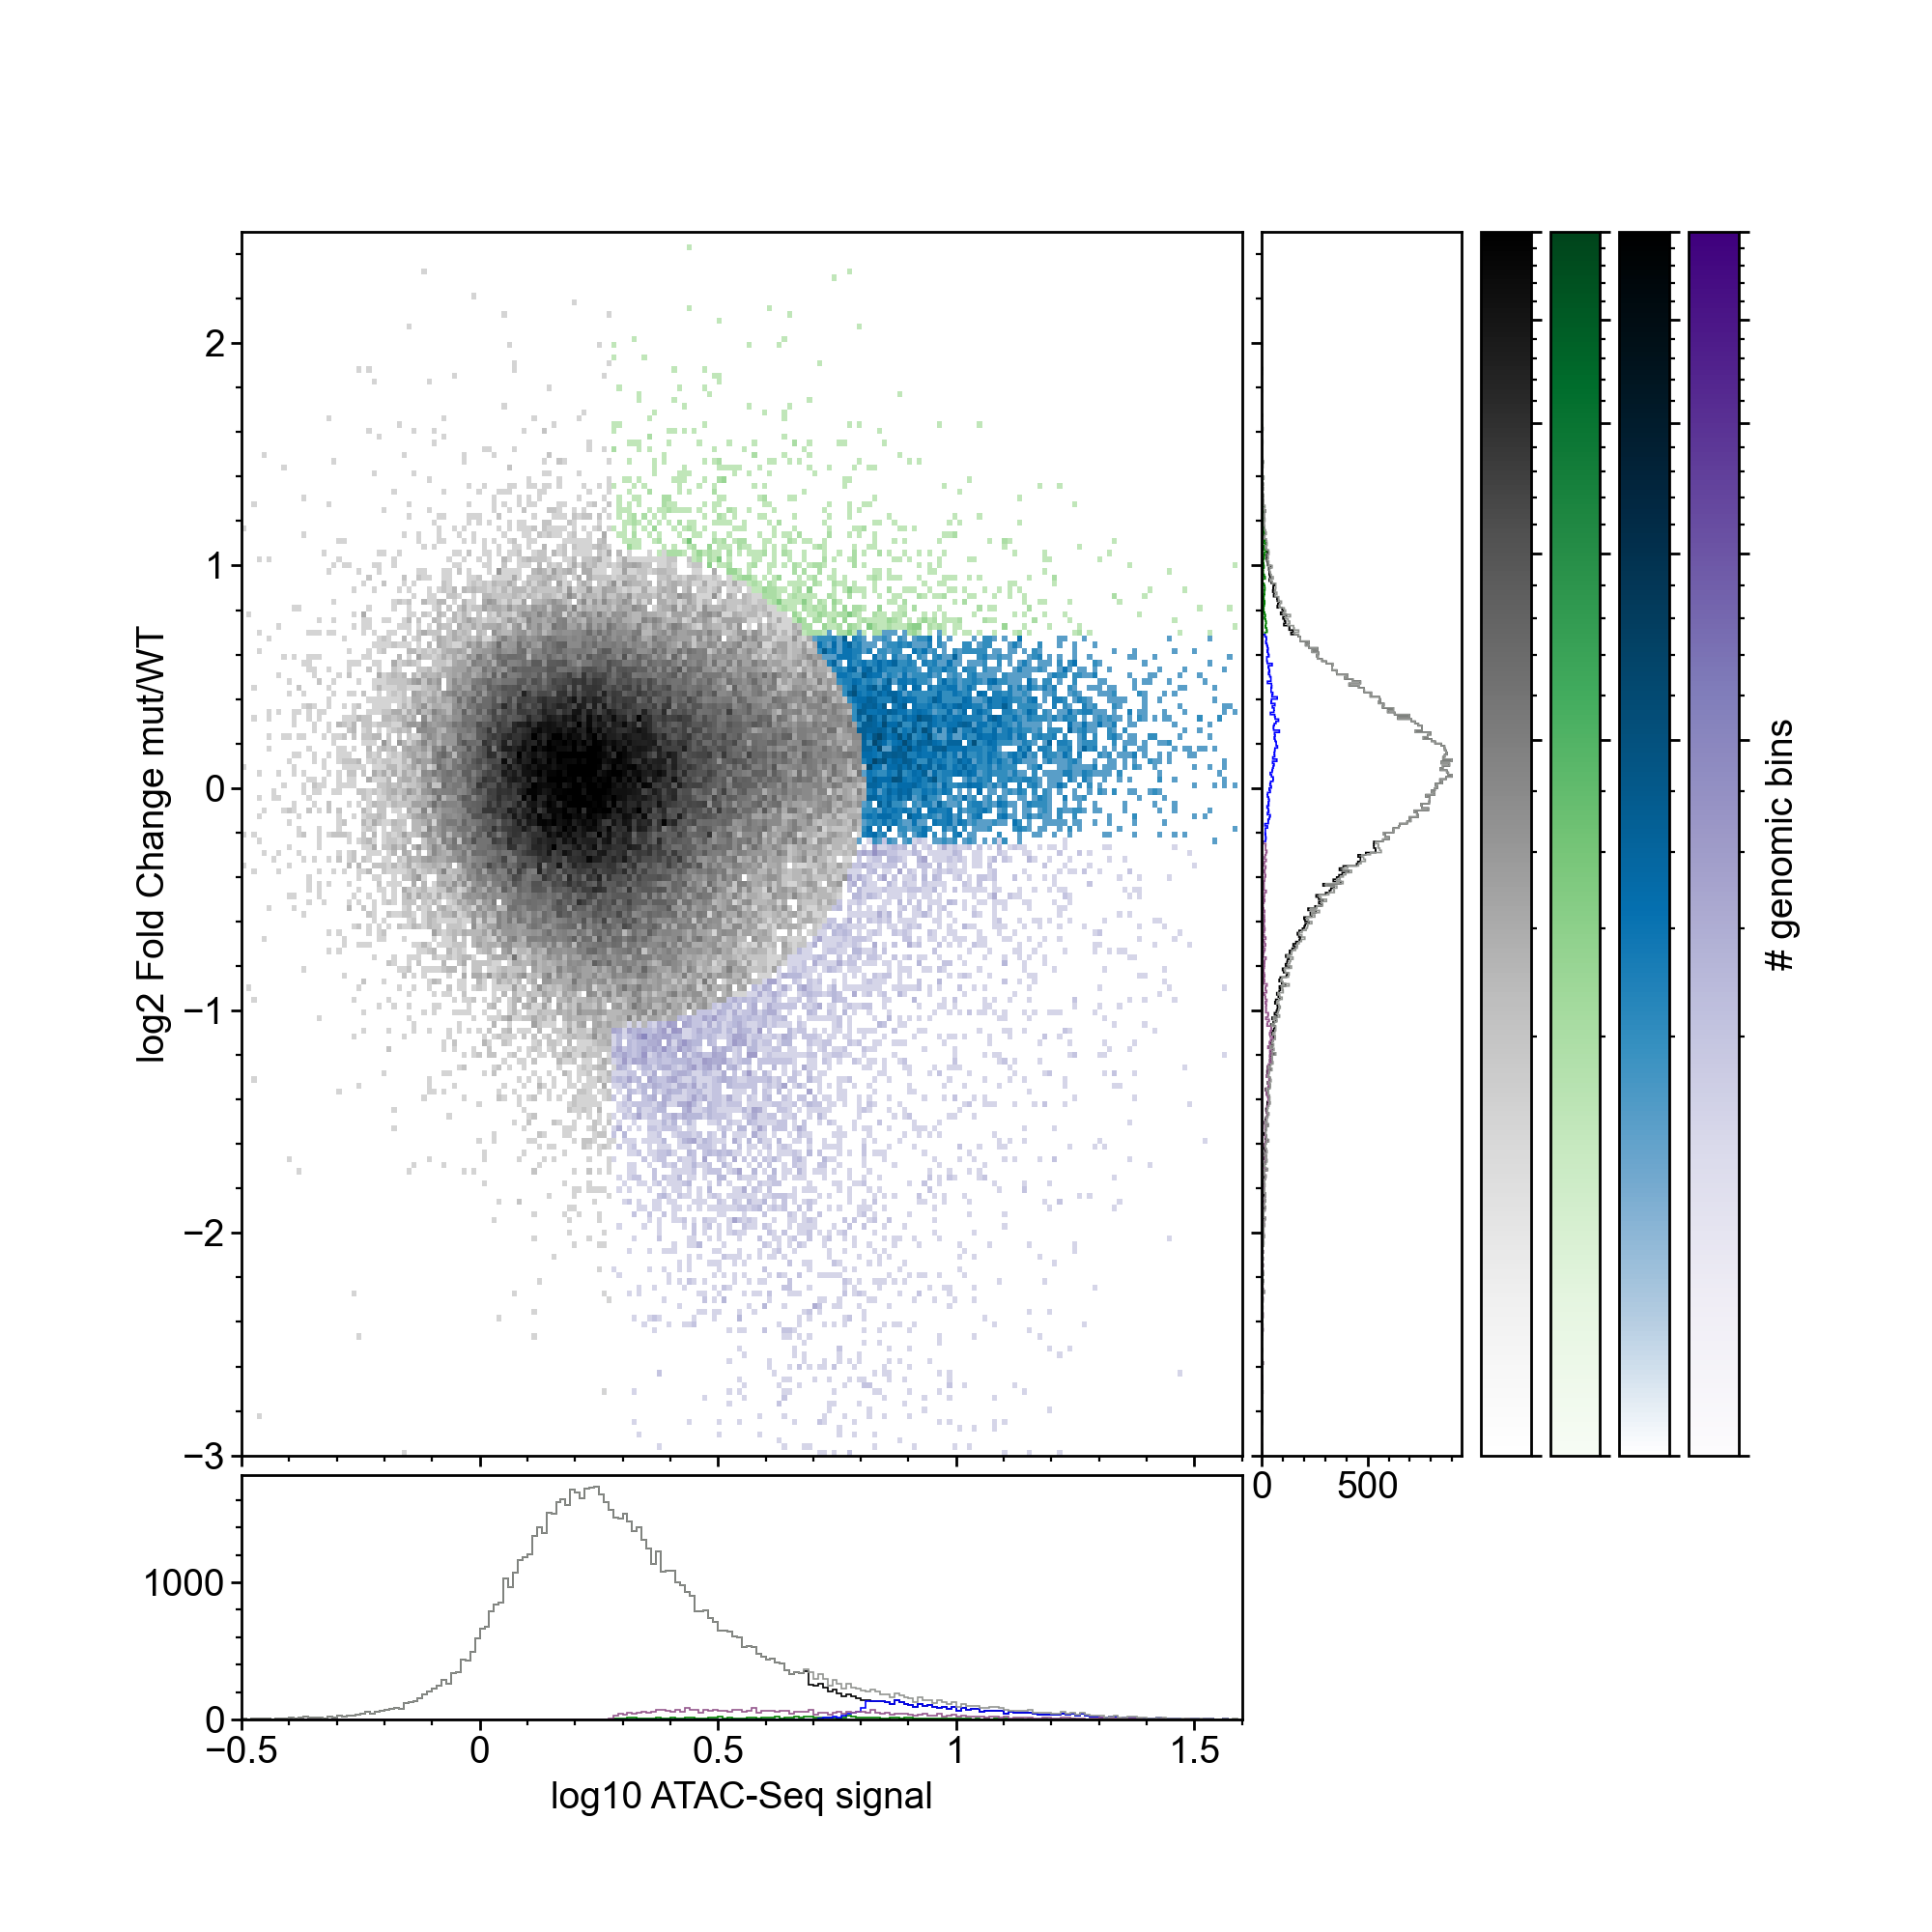

In [10]:
f, ax = plot_2D_scatterplot(
    data=df,
    x=x,
    y=y,
    idxs=[idx[x] for x in ["all other", "high up", "high unch", "high down"]],
    x_rng=(-0.5, 1.6),
    y_rng=(-3, 2.5),
    vmin_color=0,  # Color bars for counts
    vmax_color=50,
    colors=["black", "green", "blue", "purple"],
    cmaps=["grays", "greens", "blues", "purples"],
    ndots=200,
    figsize=(10, 10),
    xlabel="log10 ATAC-Seq signal",
    ylabel="log2 Fold Change mut/WT",
    cbar_label="# genomic bins",
)

if do_save:
    prefix = f"{output_folder}/Fig3C.dsshow-map"
    f.savefig(f"{prefix}.png")
    f.savefig(f"{prefix}.pdf")

In [11]:
for k, v in idx.items():
    print(k)
    df.loc[:, f"condition: {k}"] = False
    df.loc[v, f"condition: {k}"] = True

all other
FDR<0.01
high up
high unch
high down


In [12]:
cols = [
    "chrom",
    "start",
    "end",
    track1,
    track2,
    "log10(avATAC_WT)",
    "log10(avATAC_mut)",
    "log10(avATAC)",
    "log2FC(mut/WT)",
    "condition: all other",
    "condition: high up",
    "condition: high unch",
    "condition: high down",
]

if do_save:
    prefix = f"{output_folder}/Fig3C.dsshow-map"
    df.loc[:, cols].to_csv(f"{prefix}.source.tsv", sep="\t")

In [13]:
flank = 200_000

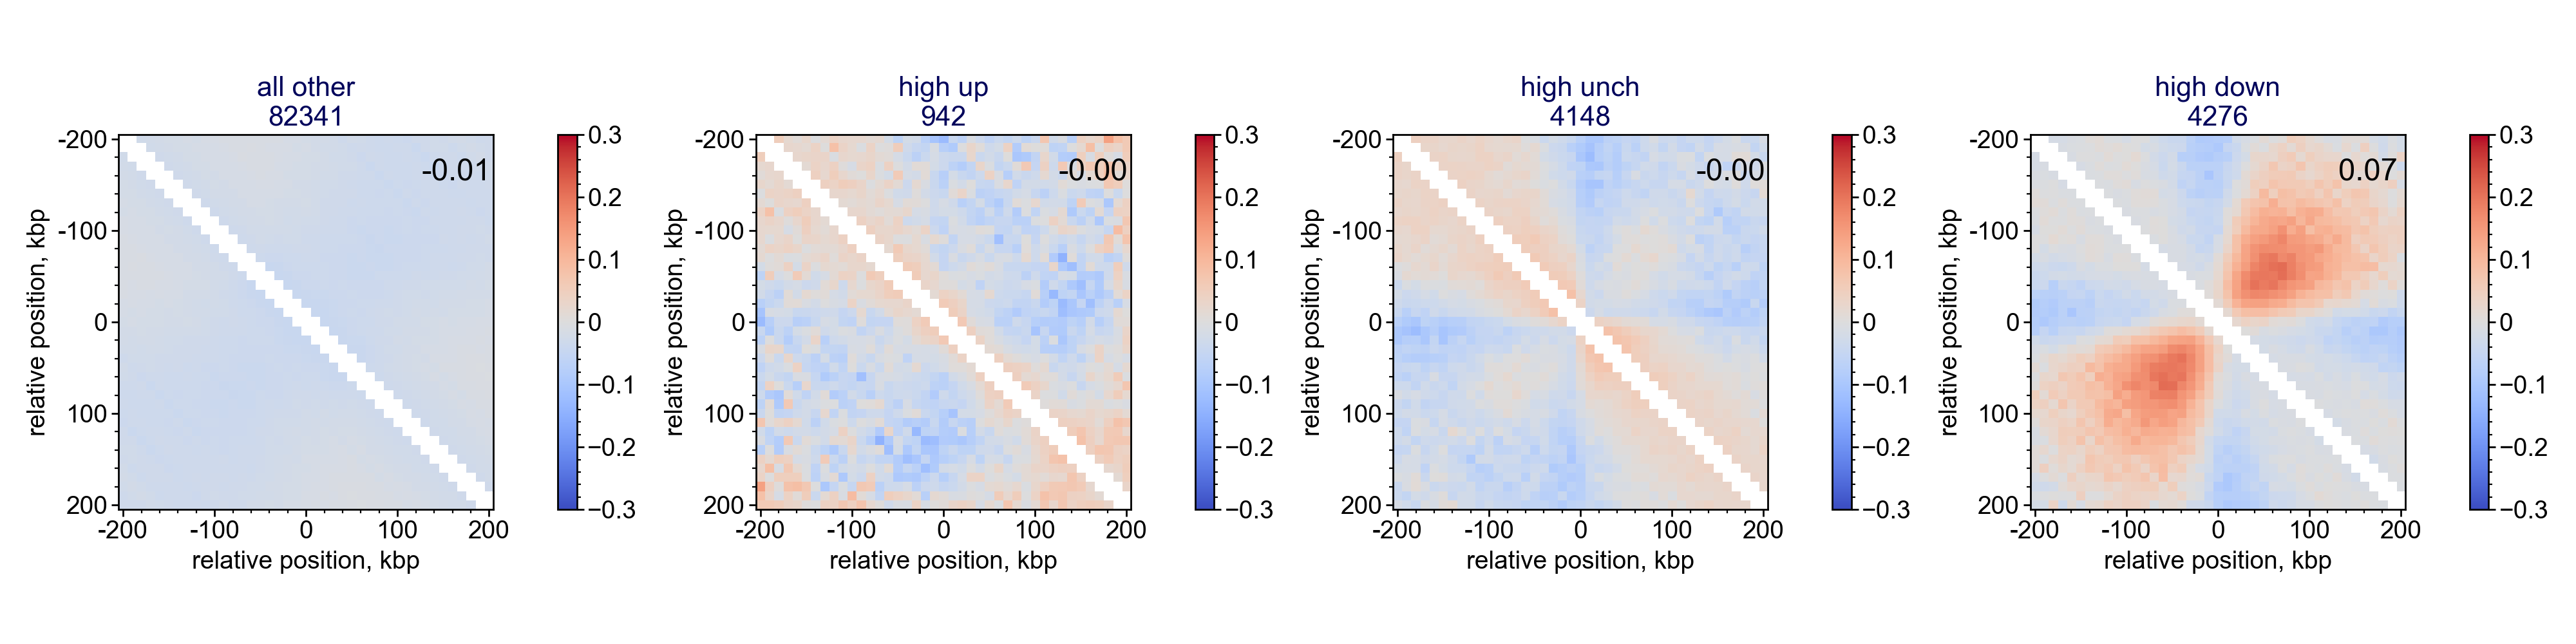

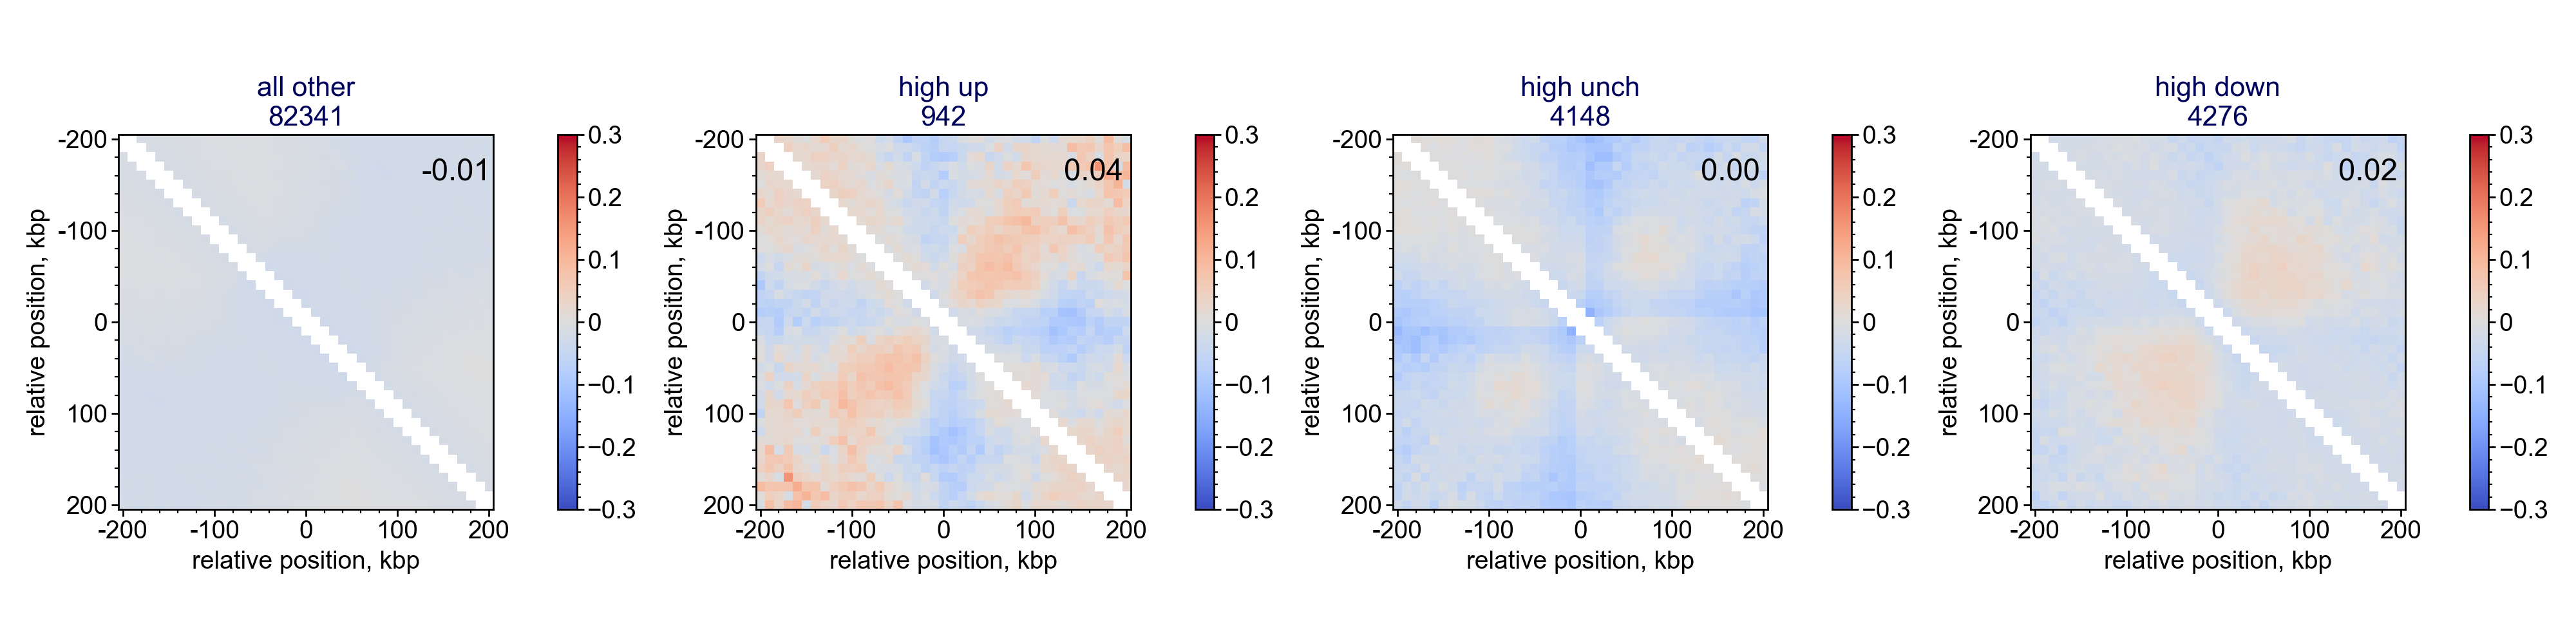

In [14]:
titles = ["all other", "high up", "high unch", "high down"]
idxs = [idx[x] for x in titles]

for source_fountains in ["WT", "TR"]:

    stacks_list = dct_stacks_hic[source_fountains]

    f = plot_pileups(
        stacks_list,
        idxs,
        titles,
        nrows=1,
        ncols=4,
        flank=flank,
        resolution=binsize,
        figsize=(20, 5),
        vmin=-0.3,
        vmax=0.3,
        reduce_ticks=False,
        cmap="coolwarm",
        avscore=df[source_fountains],
        add_counts=True,
    )
    f.show()

    if do_save:
        prefix = f"{output_folder}/Fig3D.pileup.{source_fountains}"
        f.savefig(f"{prefix}.png")
        f.savefig(f"{prefix}.pdf")

In [15]:
titles = ["all other", "high up", "high unch", "high down"]
idxs = [idx[x] for x in titles]

datasets_pileups = {}
for source_fountains in ["WT", "TR"]:

    stacks_list = dct_stacks_hic[source_fountains]

    data_pileups = plot_pileups(
        stacks_list,
        idxs,
        titles,
        avscore=df[source_fountains],
        add_counts=True,
        return_source_data=True,
    )
    datasets_pileups[source_fountains] = data_pileups

In [16]:
if do_save:
    output = []
    for source_fountains in ["WT", "TR"]:
        data_pileups = datasets_pileups[source_fountains]

        for data in data_pileups:

            df_tmp = pd.DataFrame(data[2])
            df_tmp.insert(loc=0, column="fountain score", value=data[1])
            df_tmp.insert(loc=0, column="label", value=data[0])
            df_tmp.insert(loc=0, column="source_fountains", value=source_fountains)
            output.append(df_tmp.copy())

    output = pd.concat(output, axis=0)
    prefix = f"{output_folder}/Fig3D.pileup"
    output.to_csv(f"{prefix}.source.tsv", sep="\t")

In [17]:
section_flush()

✅ Section cleaned


#### + H3K27ac analysis (SFig. 3j)

In [18]:
section_start()

✅ Section started


In [19]:
df = pd.concat([df_annotations, df_fountain_strength], axis=1).sort_index()

df.loc[df_fountains.index, df_fountains.columns] = df_fountains
df = (
    bioframe.overlap(
        df, df_clean_bins, how="left", return_index=True, suffixes=["", "_"]
    )
    .dropna(subset=["chrom_"])
    .drop_duplicates(["chrom", "start"])
)
df = df.set_index("index")

In [20]:
track1 = "H3K27ac_log2_input_WT4hpf_B1_Miao_2022"
track2 = "H3K27ac_log2_inputMZnps4hpf_Miao_2022"

df.loc[:, "avH3K27ac"] = df.loc[:, [track1, track2]].mean(axis=1)
df.loc[:, "mut-WT"] = df.loc[:, track2] - df.loc[:, track1]

In [21]:
x = "avH3K27ac"
y = "mut-WT"

In [22]:
# Set up reasonable percentiles:

th_x = np.nanpercentile(df[x], 50)
th_y = 0  # np.nanpercentile(df[y], 50)

# Reflect (symmetrize) the plot over OX percentile-based threshold:
df_symm = df.loc[(df[x] < th_x) & (df[y] > th_y), [x, y]].copy()
df_symm.loc[:, x] = th_x + (th_x - df_symm.loc[:, x])
df_symm.loc[:, y] = th_y + (th_y - df_symm.loc[:, y])

df_symm_x = df.loc[(df[x] < th_x) & (df[y] > th_y), [x, y]].copy()
df_symm_x.loc[:, x] = th_x + (th_x - df_symm_x.loc[:, x])

df_symm_y = df.loc[(df[x] < th_x) & (df[y] > th_y), [x, y]].copy()
df_symm_y.loc[:, y] = th_y + (th_y - df_symm_y.loc[:, y])

df_symm = pd.concat(
    [
        df_symm,
        df_symm_x,
        df_symm_y,
        df.loc[(df[x] < th_x) & (df[y] > th_y), [x, y]].copy(),
    ],
    axis=0,
).reset_index(drop=True)

# Fit gaussian to the reflected scatterplot:
mean, cov = fit_gaussian(df_symm, [x, y])

# Calculate FDR, transfer the parameters learned from symmetrized distribution to true distribution:
fdr = get_fdr(df, [x, y], mean, cov)
fdr_x = get_fdr(df, [x], mean, cov)
fdr_y = get_fdr(df, [y], mean, cov)

# Define selections based on FDR:
idx = {}
cond_isfinite = np.all(np.isfinite(df.loc[:, [x, y]]), axis=1)
idx["all other"] = df.loc[
    ((fdr > 0.05) | (fdr_x > 0.05) | (fdr_y > 0.05) | (df[x] < th_x)) & cond_isfinite, :
].index.values
idx["FDR<0.01"] = df.loc[(fdr < 0.05) & (fdr_y < 0.05), :].index.values

idx["high up"] = df.loc[
    ((fdr < 0.05) & (fdr_y < 0.05) & (df[x] > th_x) & (df[y] > th_y)) & cond_isfinite, :
].index.values
idx["high unch"] = df.loc[
    ((fdr < 0.05) & (fdr_y > 0.05) & (df[x] > th_x)) & cond_isfinite, :
].index.values
idx["high down"] = df.loc[
    ((fdr < 0.05) & (fdr_y < 0.05) & (df[x] > th_x) & (df[y] < th_y)) & cond_isfinite, :
].index.values

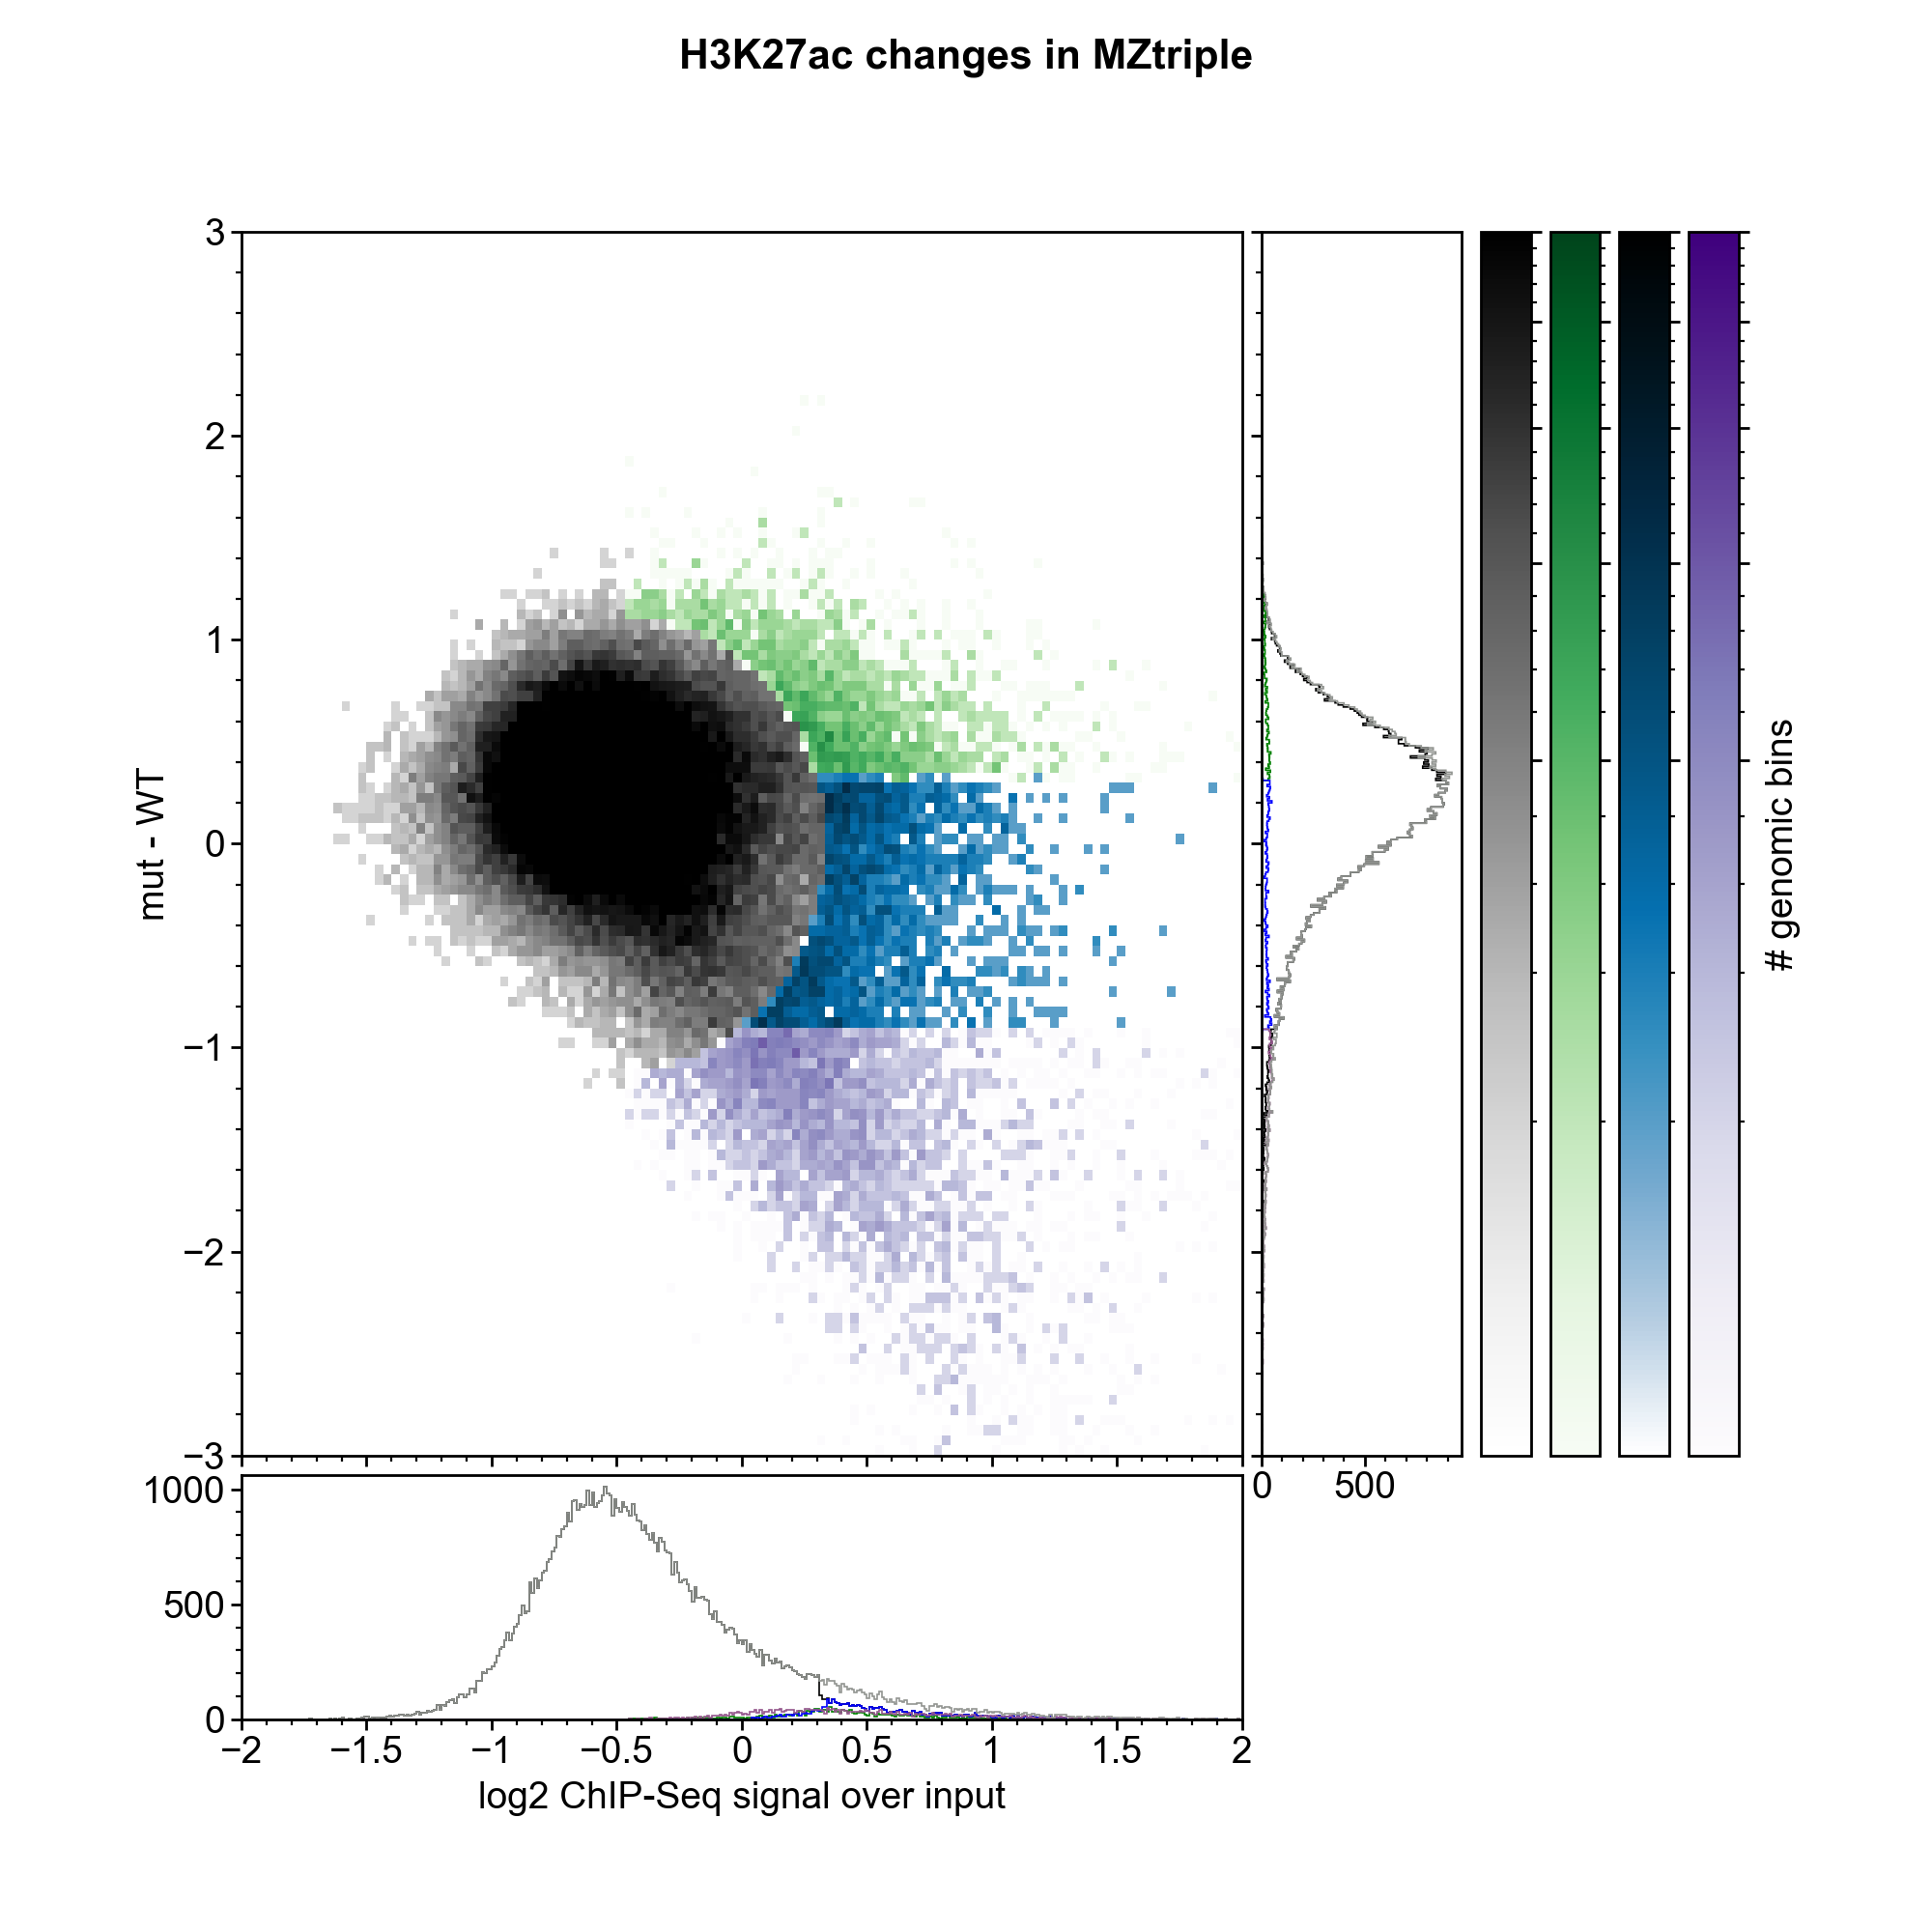

In [23]:
f, ax = plot_2D_scatterplot(
    data=df,
    x=x,
    y=y,
    idxs=[idx[x] for x in ["all other", "high up", "high unch", "high down"]],
    x_rng=(-2, 2),
    y_rng=(-3, 3),
    vmin_color=1,  # Color bars for counts
    vmax_color=50,
    colors=["black", "green", "blue", "purple"],
    cmaps=["greys", "greens", "blues", "purples"],
    ndots=120,
    figsize=(10, 10),
    xlabel="log2 ChIP-Seq signal over input",
    ylabel="mut - WT",
    cbar_label="# genomic bins",
)

f.suptitle("H3K27ac changes in MZtriple")

if do_save:
    prefix = f"{output_folder}/SFig3j.dsshow-map"
    f.savefig(f"{prefix}.png")
    f.savefig(f"{prefix}.pdf")

In [24]:
for k, v in idx.items():
    print(k)
    df.loc[:, f"condition: {k}"] = False
    df.loc[v, f"condition: {k}"] = True

all other
FDR<0.01
high up
high unch
high down


In [25]:
cols = [
    "chrom",
    "start",
    "end",
    track1,
    track2,
    "avH3K27ac",
    "mut-WT",
    "condition: all other",
    "condition: high up",
    "condition: high unch",
    "condition: high down",
]

if do_save:
    prefix = f"{output_folder}/Fig3j.dsshow-map"
    df.loc[:, cols].to_csv(f"{prefix}.source.tsv", sep="\t")

In [26]:
titles = ["all other", "high up", "high unch", "high down"]
idxs = [idx[x] for x in titles]

for source_fountains in ["WT", "TR"]:
    stacks_list = dct_stacks_hic[source_fountains]

    f = plot_pileups(
        stacks_list,
        idxs,
        titles,
        nrows=1,
        ncols=4,
        flank=flank,
        resolution=binsize,
        figsize=(20, 5),
        vmin=-0.3,
        vmax=0.3,
        reduce_ticks=False,
        cmap="coolwarm",
        avscore=df[source_fountains],
        add_counts=True,
    )
    f.show()

    f.suptitle(f"Hi-C changes in {source_fountains}")

    if do_save:
        prefix = f"{output_folder}/SFig3j.pileup.{source_fountains}"
        f.savefig(f"{prefix}.png")
        f.savefig(f"{prefix}.pdf")

NameError: name 'flank' is not defined

In [ ]:
titles = ["all other", "high up", "high unch", "high down"]
idxs = [idx[x] for x in titles]

datasets_pileups = {}
for source_fountains in ["WT", "TR"]:

    stacks_list = dct_stacks_hic[source_fountains]

    data_pileups = plot_pileups(
        stacks_list,
        idxs,
        titles,
        avscore=df[source_fountains],
        add_counts=True,
        return_source_data=True,
    )
    datasets_pileups[source_fountains] = data_pileups

In [ ]:
if do_save:
    output = []
    for source_fountains in ["WT", "TR"]:
        data_pileups = datasets_pileups[source_fountains]

        for data in data_pileups:

            df_tmp = pd.DataFrame(data[2])
            df_tmp.insert(loc=0, column="fountain score", value=data[1])
            df_tmp.insert(loc=0, column="label", value=data[0])
            df_tmp.insert(loc=0, column="source_fountains", value=source_fountains)
            output.append(df_tmp.copy())

    output = pd.concat(output, axis=0)

    prefix = f"{output_folder}/SFig3j.pileup"
    df_tmp.to_csv(f"{prefix}.source.tsv", sep="\t")

In [ ]:
section_flush()

#### + H3K4me1 analysis (SFig. 3k)

In [ ]:
section_start()

In [ ]:
df = pd.concat([df_annotations, df_fountain_strength], axis=1).sort_index()

df.loc[df_fountains.index, df_fountains.columns] = df_fountains
df = (
    bioframe.overlap(
        df, df_clean_bins, how="left", return_index=True, suffixes=["", "_"]
    )
    .dropna(subset=["chrom_"])
    .drop_duplicates(["chrom", "start"])
)
df = df.set_index("index")

In [ ]:
track1 = "log2ratio_H3K4me1_4_WT_Miao2022_B1_EXP-H3-and-histone-mod-ChIP-seq-MZnps-4h_SRX13823129_R1"
track2 = "log2ratio_H3K4me1_4_MZnps_Miao2022_B1_EXP-H3-and-histone-mod-ChIP-seq-MZnps-4h_SRX13823092_R1"

df.loc[:, "avH3K4me1"] = df.loc[:, [track1, track2]].mean(axis=1)
df.loc[:, "mut-WT"] = df.loc[:, track2] - df.loc[:, track1]

In [ ]:
x = "avH3K4me1"
y = "mut-WT"

In [ ]:
# Set up reasonable percentiles:

th_x = np.nanpercentile(df[x], 50)
th_y = 0  # np.nanpercentile(df[y], 50)

# Reflect (symmetrize) the plot over OX percentile-based threshold:
df_symm = df.loc[(df[x] < th_x) & (df[y] > th_y), [x, y]].copy()
df_symm.loc[:, x] = th_x + (th_x - df_symm.loc[:, x])
df_symm.loc[:, y] = th_y + (th_y - df_symm.loc[:, y])

df_symm_x = df.loc[(df[x] < th_x) & (df[y] > th_y), [x, y]].copy()
df_symm_x.loc[:, x] = th_x + (th_x - df_symm_x.loc[:, x])

df_symm_y = df.loc[(df[x] < th_x) & (df[y] > th_y), [x, y]].copy()
df_symm_y.loc[:, y] = th_y + (th_y - df_symm_y.loc[:, y])

df_symm = pd.concat(
    [
        df_symm,
        df_symm_x,
        df_symm_y,
        df.loc[(df[x] < th_x) & (df[y] > th_y), [x, y]].copy(),
    ],
    axis=0,
).reset_index(drop=True)

# Fit gaussian to the reflected scatterplot:
mean, cov = fit_gaussian(df_symm, [x, y])

# Calculate FDR, transfer the parameters learned from symmetrized distribution to true distribution:
fdr = get_fdr(df, [x, y], mean, cov)
fdr_x = get_fdr(df, [x], mean, cov)
fdr_y = get_fdr(df, [y], mean, cov)

# Define selections based on FDR:
idx = {}
idx["all other"] = df.loc[
    (fdr > 0.05) | (fdr_x > 0.05) | (fdr_y > 0.05), :
].index.values
idx["FDR<0.01"] = df.loc[(fdr < 0.05) & (fdr_y < 0.05), :].index.values

idx["high up"] = df.loc[
    (fdr < 0.05) & (fdr_y < 0.05) & (df[x] > th_x) & (df[y] > th_y), :
].index.values
idx["high unch"] = df.loc[
    (fdr < 0.05) & (fdr_y > 0.05) & (df[x] > th_x), :
].index.values
idx["high down"] = df.loc[
    (fdr < 0.05) & (fdr_y < 0.05) & (df[x] > th_x) & (df[y] < th_y), :
].index.values

idx["low up"] = df.loc[
    (fdr < 0.05) & (fdr_y < 0.05) & (df[x] < th_x) & (df[y] > th_y), :
].index.values
idx["low unch"] = df.loc[(fdr < 0.05) & (fdr_y > 0.05) & (df[x] < th_x), :].index.values
idx["low down"] = df.loc[
    (fdr < 0.05) & (fdr_y < 0.05) & (df[x] < th_x) & (df[y] < th_y), :
].index.values

In [ ]:
f, ax = plot_2D_scatterplot(
    data=df,
    x=x,
    y=y,
    idxs=[idx[x] for x in ["all other", "high up", "high unch", "high down"]],
    x_rng=(-0.3, 0.3),
    y_rng=(-0.3, 0.3),
    vmin_color=1,  # Color bars for counts
    vmax_color=50,
    colors=["black", "green", "blue", "purple"],
    cmaps=["greys", "greens", "blues", "purples"],
    ndots=120,
    figsize=(10, 10),
    xlabel="log2 ChIP-Seq signal over input",
    ylabel="mut - WT",
    cbar_label="# genomic bins",
)

f.suptitle("H3K4me1 changes in MZtriple")

if do_save:
    prefix = f"{output_folder}/SFig3k.dsshow-map"
    f.savefig(f"{prefix}.png")
    f.savefig(f"{prefix}.pdf")

In [ ]:
for k, v in idx.items():
    print(k)
    df.loc[:, f"condition: {k}"] = False
    df.loc[v, f"condition: {k}"] = True

In [ ]:
cols = [
    "chrom",
    "start",
    "end",
    track1,
    track2,
    "avH3K4me1",
    "mut-WT",
    "condition: all other",
    "condition: high up",
    "condition: high unch",
    "condition: high down",
]

if do_save:
    prefix = f"{output_folder}/Fig3k.dsshow-map"
    df.loc[:, cols].to_csv(f"{prefix}.source.tsv", sep="\t")

In [ ]:
titles = ["all other", "high up", "high unch", "high down"]
idxs = [idx[x] for x in titles]
for source_fountains in ["WT", "TR"]:
    stacks_list = dct_stacks_hic[source_fountains]

    f = plot_pileups(
        stacks_list,
        idxs,
        titles,
        nrows=1,
        ncols=4,
        flank=flank,
        resolution=binsize,
        figsize=(25, 5),
        vmin=-0.3,
        vmax=0.3,
        reduce_ticks=False,
        cmap="coolwarm",
        avscore=df[source_fountains],
        add_counts=True,
    )
    f.show()

    f.suptitle(f"Hi-C changes in {source_fountains}")

    if do_save:
        prefix = f"{output_folder}/SFig3k.pileup.{source_fountains}"
        f.savefig(f"{prefix}.png")
        f.savefig(f"{prefix}.pdf")

In [ ]:
titles = ["all other", "high up", "high unch", "high down"]
idxs = [idx[x] for x in titles]

datasets_pileups = {}
for source_fountains in ["WT", "TR"]:

    stacks_list = dct_stacks_hic[source_fountains]

    data_pileups = plot_pileups(
        stacks_list,
        idxs,
        titles,
        avscore=df[source_fountains],
        add_counts=True,
        return_source_data=True,
    )
    datasets_pileups[source_fountains] = data_pileups

In [ ]:
if do_save:
    output = []
    for source_fountains in ["WT", "TR"]:
        data_pileups = datasets_pileups[source_fountains]

        for data in data_pileups:

            df_tmp = pd.DataFrame(data[2])
            df_tmp.insert(loc=0, column="fountain score", value=data[1])
            df_tmp.insert(loc=0, column="label", value=data[0])
            df_tmp.insert(loc=0, column="source_fountains", value=source_fountains)
            output.append(df_tmp.copy())

    output = pd.concat(output, axis=0)

    prefix = f"{output_folder}/SFig3k.pileup"
    df_tmp.to_csv(f"{prefix}.source.tsv", sep="\t")

In [ ]:
section_flush()

## + ATAC-Seq peaks stratified by epigenetics (SFig. 3a-i)

#### + Promoter vs enhancer mark at open chromatin (Fig. 2D, SFig. 3a-c)

In [ ]:
section_start()

In [ ]:
df = pd.concat([df_annotations, df_fountain_strength], axis=1).sort_index()
df.loc[df_fountains.index, df_fountains.columns] = df_fountains
df = (
    bioframe.overlap(
        df, df_clean_bins, how="left", return_index=True, suffixes=["", "_"]
    )
    .dropna(subset=["chrom_"])
    .drop_duplicates(["chrom", "start"])
)
df = df.set_index("index")

In [ ]:
# Select those bins that have ATAC-Seq peaks:
df = (
    bioframe.overlap(df.drop(["index_"], axis=1), df_atac_peaks, return_index=True)
    .dropna(subset=["index_"])
    .groupby("index")
    .first()
)

In [ ]:
track1 = "log2ratio_H3K4me1_4_WT_Miao2022_B1_EXP-H3-and-histone-mod-ChIP-seq-MZnps-4h_SRX13823129_R1"
track2 = "log2ratio_H3K4me3_4_WT_Miao2022_B1_EXP-H3-and-histone-mod-ChIP-seq-MZnps-4h_SRX13823130_R1"

In [ ]:
f, (idx_top_both, idx_top_x, idx_bottom, idx_top_y, th_x, th_y) = (
    plot_2D_scatterplot_4way(
        data=df,
        x=track1,
        y=track2,
        x_rng=(-0.25, 0.75),
        y_rng=(-0.25, 0.75),
        xhist_stepsize=0.01,
        yhist_stepsize=0.01,
        colors=[
            "blue",
            "purple",
            "black",
            "orange",
        ],  # clockwise starting from upper right corner
        cmaps=[
            "blues",
            "purples",
            "gray_r",
            "oranges",
        ],  # clockwise starting from upper right corner
        ndots=100,
        perc_x=90,
        perc_y=90,
        th_x=None,
        th_y=None,
        figsize=(10, 10),
        xlabel="H3K4me1 signal",
        ylabel="H3K4me3 signal",
        cbar_label="# genomic bins",
    )
)

if do_save:
    prefix = f"{output_folder}/SFig3A.dsshow-map"
    f.savefig(f"{prefix}.png")
    f.savefig(f"{prefix}.pdf")

In [ ]:
th_x, th_y

In [ ]:
idx = {
    "top both": idx_top_both,
    "top x": idx_top_x,
    "bottom both": idx_bottom,
    "top y": idx_top_y,
}

for k, v in idx.items():
    print(k)
    df.loc[:, f"condition: {k}"] = False
    df.loc[v, f"condition: {k}"] = True

In [ ]:
cols = [
    "chrom",
    "start",
    "end",
    track1,
    track2,
    "condition: top both",
    "condition: top x",
    "condition: top y",
    "condition: bottom both",
]

if do_save:
    prefix = f"{output_folder}/Fig3A.dsshow-map"
    df.loc[:, cols].to_csv(f"{prefix}.source.tsv", sep="\t")

In [ ]:
idxs = [idx_top_y, idx_top_both, idx_bottom, idx_top_x]
titles = [
    "high H3K4me3 only",
    "high H3K4me3 and H3K4me1",
    "low H3K4me3 and H3K4me1",
    "high H3K4me1 only",
]

for source_fountains in ["WT", "TR"]:
    stacks_list = dct_stacks_hic[source_fountains]

    f = plot_pileups(
        stacks_list,
        idxs,
        titles,
        nrows=1,
        ncols=4,
        flank=flank,
        resolution=binsize,
        figsize=(16, 4),
        vmin=-0.2,
        vmax=0.2,
        reduce_ticks=False,
        cmap="coolwarm",
        avscore=df[source_fountains],
        add_counts=True,
    )

    if do_save:
        prefix = f"{output_folder}/SFig3A.pileup.{source_fountains}"
        f.savefig(f"{prefix}.png")
        f.savefig(f"{prefix}.pdf")

In [ ]:
idxs = [idx_top_y, idx_top_both, idx_bottom, idx_top_x]
titles = [
    "high H3K4me3 only",
    "high H3K4me3 and H3K4me1",
    "low H3K4me3 and H3K4me1",
    "high H3K4me1 only",
]

datasets_pileups = {}
for source_fountains in ["WT", "TR"]:

    stacks_list = dct_stacks_hic[source_fountains]

    data_pileups = plot_pileups(
        stacks_list,
        idxs,
        titles,
        avscore=df[source_fountains],
        add_counts=True,
        return_source_data=True,
    )
    datasets_pileups[source_fountains] = data_pileups

In [ ]:
if do_save:
    output = []
    for source_fountains in ["WT", "TR"]:
        data_pileups = datasets_pileups[source_fountains]

        for data in data_pileups:

            df_tmp = pd.DataFrame(data[2])
            df_tmp.insert(loc=0, column="fountain score", value=data[1])
            df_tmp.insert(loc=0, column="label", value=data[0])
            df_tmp.insert(loc=0, column="source_fountains", value=source_fountains)
            output.append(df_tmp.copy())

    output = pd.concat(output, axis=0)

    prefix = f"{output_folder}/SFig3A.pileup"
    output.to_csv(f"{prefix}.source.tsv", sep="\t")

In [ ]:
section_flush()

#### + Promoter vs enhancer marks at acetylated open regions (SFig. 3D-F)

In [ ]:
section_start()

In [ ]:
df = pd.concat([df_annotations, df_fountain_strength], axis=1).sort_index()
df.loc[df_fountains.index, df_fountains.columns] = df_fountains
df = (
    bioframe.overlap(
        df, df_clean_bins, how="left", return_index=True, suffixes=["", "_"]
    )
    .dropna(subset=["chrom_"])
    .drop_duplicates(["chrom", "start"])
)
df = df.set_index("index")

In [ ]:
track1 = "log2ratio_H3K4me1_4_WT_Miao2022_B1_EXP-H3-and-histone-mod-ChIP-seq-MZnps-4h_SRX13823129_R1"
track2 = "log2ratio_H3K4me3_4_WT_Miao2022_B1_EXP-H3-and-histone-mod-ChIP-seq-MZnps-4h_SRX13823130_R1"
track3 = (
    "log2ratio_H3K27ac_4_WT_Miao2022_B2_EXP-H3K27ac-ChIP-seq-MZnps-4h_SRX13823199_R1"
)

In [ ]:
th_z = np.percentile(df[track3], 90)

In [ ]:
# Select those bins that have high H3K27ac:
df = df.loc[df[track3] > th_z, :]

# Select those bins that have ATAC-Seq peaks:
df = (
    bioframe.overlap(df.drop(["index_"], axis=1), df_atac_peaks, return_index=True)
    .dropna(subset=["index_"])
    .groupby("index")
    .first()
)

In [ ]:
f, (idx_top_both, idx_top_x, idx_bottom, idx_top_y, th_x, th_y) = (
    plot_2D_scatterplot_4way(
        data=df,
        x=track1,
        y=track2,
        x_rng=(-0.25, 0.75),
        y_rng=(-0.25, 0.75),
        xhist_stepsize=0.01,
        yhist_stepsize=0.01,
        colors=[
            "blue",
            "purple",
            "black",
            "orange",
        ],  # clockwise starting from upper right corner
        cmaps=[
            "blues",
            "purples",
            "gray_r",
            "oranges",
        ],  # clockwise starting from upper right corner
        ndots=100,
        perc_x=60,
        perc_y=60,
        th_x=None,
        th_y=None,
        figsize=(10, 10),
        xlabel="H3K4me1 signal",
        ylabel="H3K4me3 signal",
        cbar_label="# genomic bins",
    )
)

if do_save:
    prefix = f"{output_folder}/SFig3D.dsshow-map"
    f.savefig(f"{prefix}.png")
    f.savefig(f"{prefix}.pdf")

In [ ]:
th_x, th_y, th_z

In [ ]:
idx = {
    "top both": idx_top_both,
    "top x": idx_top_x,
    "bottom both": idx_bottom,
    "top y": idx_top_y,
}

for k, v in idx.items():
    print(k)
    df.loc[:, f"condition: {k}"] = False
    df.loc[v, f"condition: {k}"] = True

In [ ]:
cols = [
    "chrom",
    "start",
    "end",
    track1,
    track2,
    track3,
    "condition: top both",
    "condition: top x",
    "condition: top y",
    "condition: bottom both",
]

if do_save:
    prefix = f"{output_folder}/Fig3D.dsshow-map"
    df.loc[:, cols].to_csv(f"{prefix}.source.tsv", sep="\t")

In [ ]:
idxs = [idx_top_y, idx_top_both, idx_bottom, idx_top_x]
titles = [
    "high H3K4me3 only",
    "high H3K4me3 and H3K4me1",
    "low H3K4me3 and H3K4me1",
    "high H3K4me1 only",
]

for source_fountains in ["WT", "TR"]:
    stacks_list = dct_stacks_hic[source_fountains]

    f = plot_pileups(
        stacks_list,
        idxs,
        titles,
        nrows=1,
        ncols=4,
        flank=200_000,
        resolution=10_000,
        figsize=(16, 4),
        vmin=-0.3,
        vmax=0.3,
        reduce_ticks=False,
        cmap="coolwarm",
        avscore=df[source_fountains],
        add_counts=True,
    )

    if do_save:
        prefix = f"{output_folder}/SFig3D.pileup.{source_fountains}"
        f.savefig(f"{prefix}.png")
        f.savefig(f"{prefix}.pdf")

In [ ]:
idxs = [idx_top_y, idx_top_both, idx_bottom, idx_top_x]
titles = [
    "high H3K4me3 only",
    "high H3K4me3 and H3K4me1",
    "low H3K4me3 and H3K4me1",
    "high H3K4me1 only",
]

datasets_pileups = {}
for source_fountains in ["WT", "TR"]:

    stacks_list = dct_stacks_hic[source_fountains]

    data_pileups = plot_pileups(
        stacks_list,
        idxs,
        titles,
        avscore=df[source_fountains],
        add_counts=True,
        return_source_data=True,
    )
    datasets_pileups[source_fountains] = data_pileups

In [ ]:
if do_save:
    output = []
    for source_fountains in ["WT", "TR"]:
        data_pileups = datasets_pileups[source_fountains]

        for data in data_pileups:

            df_tmp = pd.DataFrame(data[2])
            df_tmp.insert(loc=0, column="fountain score", value=data[1])
            df_tmp.insert(loc=0, column="label", value=data[0])
            df_tmp.insert(loc=0, column="source_fountains", value=source_fountains)
            output.append(df_tmp.copy())

    output = pd.concat(output, axis=0)

    prefix = f"{output_folder}/SFig3D.pileup"
    output.to_csv(f"{prefix}.source.tsv", sep="\t")

In [ ]:
section_flush()

#### + Promoter vs enhancer marks at non-acetylated open regions (SFig. 3G-I)

In [ ]:
section_start()

In [ ]:
df = pd.concat([df_annotations, df_fountain_strength], axis=1).sort_index()
df.loc[df_fountains.index, df_fountains.columns] = df_fountains
df = (
    bioframe.overlap(
        df, df_clean_bins, how="left", return_index=True, suffixes=["", "_"]
    )
    .dropna(subset=["chrom_"])
    .drop_duplicates(["chrom", "start"])
)
df = df.set_index("index")

In [ ]:
track1 = "log2ratio_H3K4me1_4_WT_Miao2022_B1_EXP-H3-and-histone-mod-ChIP-seq-MZnps-4h_SRX13823129_R1"
track2 = "log2ratio_H3K4me3_4_WT_Miao2022_B1_EXP-H3-and-histone-mod-ChIP-seq-MZnps-4h_SRX13823130_R1"
track3 = (
    "log2ratio_H3K27ac_4_WT_Miao2022_B2_EXP-H3K27ac-ChIP-seq-MZnps-4h_SRX13823199_R1"
)

In [ ]:
th_z = np.percentile(df[track3], 10)

In [ ]:
# Select those bins that have high H3K27ac:
df = df.loc[df[track3] < th_z, :]

# Select those bins that have ATAC-Seq peaks:
df = (
    bioframe.overlap(df.drop(["index_"], axis=1), df_atac_peaks, return_index=True)
    .dropna(subset=["index_"])
    .groupby("index")
    .first()
)

In [ ]:
f, (idx_top_both, idx_top_x, idx_bottom, idx_top_y, th_x, th_y) = (
    plot_2D_scatterplot_4way(
        data=df,
        x=track1,
        y=track2,
        x_rng=(-0.15, 0.4),
        y_rng=(-0.15, 0.1),
        xhist_stepsize=0.01,
        yhist_stepsize=0.01,
        colors=[
            "blue",
            "purple",
            "black",
            "orange",
        ],  # clockwise starting from upper right corner
        cmaps=[
            "blues",
            "purples",
            "gray_r",
            "oranges",
        ],  # clockwise starting from upper right corner
        ndots=100,
        perc_x=60,
        perc_y=60,
        th_x=None,
        th_y=None,
        figsize=(10, 10),
        xlabel="H3K4me1 signal",
        ylabel="H3K4me3 signal",
        cbar_label="# genomic bins",
    )
)

if do_save:
    prefix = f"{output_folder}/SFig3G.dsshow-map"
    f.savefig(f"{prefix}.png")
    f.savefig(f"{prefix}.pdf")

In [ ]:
th_x, th_y, th_z

In [ ]:
idx = {
    "top both": idx_top_both,
    "top x": idx_top_x,
    "bottom both": idx_bottom,
    "top y": idx_top_y,
}

for k, v in idx.items():
    print(k)
    df.loc[:, f"condition: {k}"] = False
    df.loc[v, f"condition: {k}"] = True

In [ ]:
cols = [
    "chrom",
    "start",
    "end",
    track1,
    track2,
    track3,
    "condition: top both",
    "condition: top x",
    "condition: top y",
    "condition: bottom both",
]

if do_save:
    prefix = f"{output_folder}/Fig3G.dsshow-map"
    df.loc[:, cols].to_csv(f"{prefix}.source.tsv", sep="\t")

In [ ]:
idxs = [idx_top_y, idx_top_both, idx_bottom, idx_top_x]
titles = [
    "high H3K4me3 only",
    "high H3K4me3 and H3K4me1",
    "low H3K4me3 and H3K4me1",
    "high H3K4me1 only",
]

for source_fountains in ["WT", "TR"]:
    stacks_list = dct_stacks_hic[source_fountains]

    f = plot_pileups(
        stacks_list,
        idxs,
        titles,
        nrows=1,
        ncols=4,
        flank=flank,
        resolution=binsize,
        figsize=(16, 4),
        vmin=-0.3,
        vmax=0.3,
        reduce_ticks=False,
        cmap="coolwarm",
        avscore=df[source_fountains],
        add_counts=True,
    )

    if do_save:
        prefix = f"{output_folder}/SFig3G.pileup.{source_fountains}"
        f.savefig(f"{prefix}.png")
        f.savefig(f"{prefix}.pdf")

In [ ]:
idxs = [idx_top_y, idx_top_both, idx_bottom, idx_top_x]
titles = [
    "high H3K4me3 only",
    "high H3K4me3 and H3K4me1",
    "low H3K4me3 and H3K4me1",
    "high H3K4me1 only",
]

datasets_pileups = {}
for source_fountains in ["WT", "TR"]:

    stacks_list = dct_stacks_hic[source_fountains]

    data_pileups = plot_pileups(
        stacks_list,
        idxs,
        titles,
        avscore=df[source_fountains],
        add_counts=True,
        return_source_data=True,
    )
    datasets_pileups[source_fountains] = data_pileups

In [ ]:
if do_save:
    output = []
    for source_fountains in ["WT", "TR"]:
        data_pileups = datasets_pileups[source_fountains]

        for data in data_pileups:

            df_tmp = pd.DataFrame(data[2])
            df_tmp.insert(loc=0, column="fountain score", value=data[1])
            df_tmp.insert(loc=0, column="label", value=data[0])
            df_tmp.insert(loc=0, column="source_fountains", value=source_fountains)
            output.append(df_tmp.copy())

    output = pd.concat(output, axis=0)

    prefix = f"{output_folder}/SFig3G.pileup"
    output.to_csv(f"{prefix}.source.tsv", sep="\t")

In [ ]:
section_flush()

## - Properties of fountains (SFig. 2 elements)

#### + Rad21 enrichment (SFig. 2b)

In [ ]:
section_start()

In [ ]:
df = pd.concat([df_annotations, df_fountain_strength], axis=1).sort_index()

df.loc[df_fountains.index, df_fountains.columns] = df_fountains
df = (
    bioframe.overlap(
        df, df_clean_bins, how="left", return_index=True, suffixes=["", "_"]
    )
    .dropna(subset=["chrom_"])
    .drop_duplicates(["chrom", "start"])
)
df = df.set_index("index")

In [ ]:
# Take only fountains
df = df.dropna(subset=["SIM"])

In [ ]:
track1 = "Rad21_Wike_4_log2_ChIP_input"
track2 = "WT"

In [ ]:
v = df.loc[:, track1]
ths = np.percentile(v, [25, 50, 75, 90])

In [ ]:
v = df.loc[:, track1].values

plt.figure(figsize=[7, 3])
sns.histplot(v)
for th in ths:
    plt.axvline(th, color="red", linewidth=0.7)
plt.tight_layout()

In [ ]:
# Define selections based on thresholds:
idx = {}
cond_isfinite = np.isfinite(df[track1]) & np.isfinite(df[track2])
idx["all"] = df.loc[cond_isfinite, :].index.values
idx["<25%"] = df.loc[(df.loc[:, track1] <= ths[0]) & cond_isfinite, :].index.values
idx["25%-50%"] = df.loc[
    (df.loc[:, track1] > ths[0]) & (df.loc[:, track1] <= ths[1]) & cond_isfinite, :
].index.values
idx["50%-75%"] = df.loc[
    (df.loc[:, track1] > ths[1]) & (df.loc[:, track1] <= ths[2]) & cond_isfinite, :
].index.values
idx["75%-90%"] = df.loc[
    (df.loc[:, track1] > ths[2]) & (df.loc[:, track1] <= ths[3]) & cond_isfinite, :
].index.values
idx[">90%"] = df.loc[(df.loc[:, track1] > ths[3]) & cond_isfinite, :].index.values

In [ ]:
titles = ["all", "<25%", "25%-50%", "50%-75%", "75%-90%", ">90%"]
f, ax = plot_2D_scatterplot(
    data=df,
    x=track1,
    y=track2,
    idxs=[idx[x] for x in titles],
    titles=titles,
    x_rng=(-0.75, 1.25),
    y_rng=(0, 0.6),
    xhist_stepsize=0.01,
    yhist_stepsize=0.01,
    vmin_color=0,  # Color bars for counts
    vmax_color=10,
    colors=["grey"] + [mpl.cm.get_cmap("magma", 6)(i) for i in range(5)],
    ndots=100,
    figsize=(10, 10),
    xlabel="log2(Rad21/input)",
    ylabel="Fountain strength WT",
    cbar_label="# genomic bins",
    kind="regplot",
)

if do_save:
    prefix = f"{output_folder}/SFig2B.scatter"
    f.savefig(f"{prefix}.png")
    f.savefig(f"{prefix}.pdf")

In [ ]:
for k, v in idx.items():
    print(k)
    df.loc[:, f"condition: {k}"] = False
    df.loc[v, f"condition: {k}"] = True

cols = [
    "chrom",
    "start",
    "end",
    track1,
    track2,
    "condition: all",
    "condition: <25%",
    "condition: 50%-75%",
    "condition: 75%-90%",
    "condition: >90%",
]

if do_save:
    prefix = f"{output_folder}/SFig2B.scatter"
    df.loc[:, cols].to_csv(f"{prefix}.source.tsv", sep="\t")

In [ ]:
flank = 200_000
titles = ["all", "<25%", "25%-50%", "50%-75%", "75%-90%", ">90%"]
idxs = [idx[x] for x in titles]
for source_fountains in ["WT"]:
    stacks_list = dct_stacks_hic[source_fountains]

    f = plot_pileups(
        stacks_list,
        idxs,
        titles,
        nrows=1,
        ncols=6,
        flank=flank,
        resolution=binsize,
        figsize=(30, 5),
        vmin=-0.5,
        vmax=0.5,
        reduce_ticks=False,
        cmap="coolwarm",
        avscore=df[source_fountains],
        add_counts=True,
    )
    if do_save:
        prefix = f"{output_folder}/SFig2B.pileup.{source_fountains}"
        f.savefig(f"{prefix}.png")
        f.savefig(f"{prefix}.pdf")

In [ ]:
titles = ["<25%", "25%-50%", "50%-75%", "75%-90%", ">90%", "all"]
idxs = [idx[x] for x in titles]

datasets_pileups = {}
for source_fountains in ["WT"]:

    stacks_list = dct_stacks_hic[source_fountains]

    data_pileups = plot_pileups(
        stacks_list,
        idxs,
        titles,
        avscore=df[source_fountains],
        add_counts=True,
        return_source_data=True,
    )
    datasets_pileups[source_fountains] = data_pileups

In [ ]:
if do_save:
    for source_fountains in ["WT"]:
        data_pileups = datasets_pileups[source_fountains]

        for data in data_pileups:

            df_tmp = pd.DataFrame(data[2])
            df_tmp.insert(loc=0, column="fountain score", value=data[1])
            df_tmp.insert(loc=0, column="label", value=data[0])
            df_tmp.insert(loc=0, column="source_fountains", value=source_fountains)

            prefix = f"{output_folder}/SFig2B.pileup.{source_fountains}.{data[0]}"
            df_tmp.to_csv(f"{prefix}.source.tsv", sep="\t")

In [ ]:
section_flush()

### + Distance to CTCF (SFig. 2G)

In [ ]:
section_start()

In [ ]:
df = pd.concat([df_annotations, df_fountain_strength], axis=1).sort_index()

df.loc[df_fountains.index, df_fountains.columns] = df_fountains
df = (
    bioframe.overlap(
        df, df_clean_bins, how="left", return_index=True, suffixes=["", "_"]
    )
    .dropna(subset=["chrom_"])
    .drop_duplicates(["chrom", "start"])
)
df = df.set_index("index")

In [ ]:
df = (
    bioframe.closest(
        df,
        df_ctcf,
        ignore_overlaps=False,
        ignore_upstream=False,
        ignore_downstream=False,
        k=1,
        return_index=True,
    )
    .reset_index(drop=True)
    .set_index("index")
    .sort_index()
)

In [ ]:
track1 = "log(distance to CTCF)"
df.loc[:, track1] = np.log10(df["distance"]).astype(np.float32).replace(-np.inf, 0)

track2 = "WT"

In [ ]:
# Retain only fountains:
df = df.dropna(subset=["SIM"])

In [ ]:
# Define selections based on FDR:
idx = {}
idx["all"] = df.loc[np.isfinite(df.distance), :].index.values
idx["at CTCF"] = df.loc[df.distance == 0, :].index.values
idx["proximal (0-50Kb)"] = df.loc[
    (df.distance > 0) * (df.distance <= 50_000), :
].index.values
idx["proximal-medium (50-100Kb)"] = df.loc[
    (df.distance > 50_000) * (df.distance <= 100_000), :
].index.values
idx["medium-range (100-200Kb)"] = df.loc[
    (df.distance > 100_000) * (df.distance <= 200_000), :
].index.values
idx["distal (>200Kb)"] = df.loc[(df.distance > 200_000), :].index.values

In [ ]:
titles = [
    "all",
    "at CTCF",
    "proximal (0-50Kb)",
    "proximal-medium (50-100Kb)",
    "medium-range (100-200Kb)",
    "distal (>200Kb)",
]
f, ax = plot_2D_scatterplot(
    data=df,
    x=track1,
    y=track2,
    idxs=[idx[x] for x in titles],
    titles=titles,
    x_rng=(-0.1, 6),
    y_rng=(0, 0.7),
    xhist_stepsize=0.1,
    yhist_stepsize=0.01,
    vmin_color=0,  # Color bars for counts
    vmax_color=10,
    colors=["grey"] + [mpl.cm.get_cmap("magma", 6)(i) for i in range(5)],
    # cmaps  = ['greys', 'greens', 'blues', 'purples', 'oranges', 'reds'],
    ndots=100,
    figsize=(10, 10),
    xlabel="log10 distance to CTCF",
    ylabel="Fountain strength WT",
    cbar_label="# genomic bins",
    kind="regplot",
)

if do_save:
    prefix = f"{output_folder}/SFig2G.scatter"
    f.savefig(f"{prefix}.png")
    f.savefig(f"{prefix}.pdf")

In [ ]:
for k, v in idx.items():
    print(k)
    df.loc[:, f"condition: {k}"] = False
    df.loc[v, f"condition: {k}"] = True

cols = [
    "chrom",
    "start",
    "end",
    "distance",
    track1,
    track2,
    "condition: all",
    "condition: at CTCF",
    "condition: proximal (0-50Kb)",
    "condition: proximal-medium (50-100Kb)",
    "condition: medium-range (100-200Kb)",
    "condition: distal (>200Kb)",
]

if do_save:
    prefix = f"{output_folder}/SFig2G.scatter"
    df.loc[:, cols].to_csv(f"{prefix}.source.tsv", sep="\t")

In [ ]:
flank = 200_000

titles = [
    "at CTCF",
    "proximal (0-50Kb)",
    "proximal-medium (50-100Kb)",
    "medium-range (100-200Kb)",
    "distal (>200Kb)",
]
idxs = [idx[x] for x in titles]

for source_fountains in ["WT"]:
    stacks_list = dct_stacks_hic[source_fountains]

    f = plot_pileups(
        stacks_list,
        idxs,
        titles,
        nrows=1,
        ncols=5,
        flank=flank,
        resolution=binsize,
        figsize=(25, 5),
        vmin=-0.5,
        vmax=0.5,
        reduce_ticks=False,
        cmap="coolwarm",
        avscore=df[source_fountains],
        add_counts=True,
    )

    if do_save:
        prefix = f"{output_folder}/SFig2G.pileup.{source_fountains}"
        f.savefig(f"{prefix}.png")
        f.savefig(f"{prefix}.pdf")

In [ ]:
titles = [
    "at CTCF",
    "proximal (0-50Kb)",
    "proximal-medium (50-100Kb)",
    "medium-range (100-200Kb)",
    "distal (>200Kb)",
]
idxs = [idx[x] for x in titles]

datasets_pileups = {}
for source_fountains in ["WT"]:

    stacks_list = dct_stacks_hic[source_fountains]

    data_pileups = plot_pileups(
        stacks_list,
        idxs,
        titles,
        avscore=df[source_fountains],
        add_counts=True,
        return_source_data=True,
    )
    datasets_pileups[source_fountains] = data_pileups

In [ ]:
if do_save:
    for source_fountains in ["WT"]:
        data_pileups = datasets_pileups[source_fountains]

        for data in data_pileups:

            df_tmp = pd.DataFrame(data[2])
            df_tmp.insert(loc=0, column="fountain score", value=data[1])
            df_tmp.insert(loc=0, column="label", value=data[0])
            df_tmp.insert(loc=0, column="source_fountains", value=source_fountains)

            prefix = f"{output_folder}/SFig2G.pileup.{source_fountains}.{data[0]}"
            df_tmp.to_csv(f"{prefix}.source.tsv", sep="\t")

In [ ]:
section_flush()

### + Distance to TSSs  (SFig. 2H)

In [ ]:
section_start()

In [ ]:
cond = df_tss_annotated["blastula dome"] > 0
cond &= df_tss_annotated["is_maternal"] == False
df_genes_selected = df_tss_annotated.loc[cond, :].reset_index(drop=True)

In [ ]:
len(df_genes_selected)

In [ ]:
df = pd.concat([df_annotations, df_fountain_strength], axis=1).sort_index()

df.loc[df_fountains.index, df_fountains.columns] = df_fountains
df = (
    bioframe.overlap(
        df, df_clean_bins, how="left", return_index=True, suffixes=["", "_"]
    )
    .dropna(subset=["chrom_"])
    .drop_duplicates(["chrom", "start"])
)
df = df.set_index("index")

In [ ]:
df = (
    bioframe.closest(
        df,
        df_genes_selected,
        ignore_overlaps=False,
        ignore_upstream=False,
        ignore_downstream=False,
        k=1,
        return_index=True,
    )
    .reset_index(drop=True)
    .set_index("index")
    .sort_index()
)

In [ ]:
track1 = "log(distance to gene)"
df.loc[:, track1] = np.log10(df["distance"]).astype(np.float32).replace(-np.inf, 0)

track2 = "WT"

In [ ]:
# Retain only fountains:
df = df.dropna(subset=["SIM"])

In [ ]:
# Define selections based on FDR:
idx = {}
idx["all"] = df.loc[np.isfinite(df.distance), :].index.values
idx["at gene"] = df.loc[df.distance == 0, :].index.values
idx["proximal (0-50Kb)"] = df.loc[
    (df.distance > 0) * (df.distance <= 50_000), :
].index.values
idx["proximal-medium (50-100Kb)"] = df.loc[
    (df.distance > 50_000) * (df.distance <= 100_000), :
].index.values
idx["medium-range (100-200Kb)"] = df.loc[
    (df.distance > 100_000) * (df.distance <= 200_000), :
].index.values
idx["distal (>200Kb)"] = df.loc[(df.distance > 200_000), :].index.values

In [ ]:
titles = [
    "all",
    "at gene",
    "proximal (0-50Kb)",
    "proximal-medium (50-100Kb)",
    "medium-range (100-200Kb)",
    "distal (>200Kb)",
]
f, ax = plot_2D_scatterplot(
    data=df,
    x=track1,
    y=track2,
    idxs=[idx[x] for x in titles],
    titles=titles,
    x_rng=(-0.1, 6),
    y_rng=(0, 0.5),
    xhist_stepsize=0.1,
    yhist_stepsize=0.01,
    vmin_color=0,  # Color bars for counts
    vmax_color=10,
    colors=["grey"] + [mpl.cm.get_cmap("magma", 6)(i) for i in range(5)],
    # cmaps  = ['greys', 'greens', 'blues', 'purples', 'oranges', 'reds'],
    ndots=100,
    figsize=(10, 10),
    xlabel="log10 distance to gene",
    ylabel="Fountain strength WT",
    cbar_label="# genomic bins",
    kind="regplot",
)

if do_save:
    prefix = f"{output_folder}/SFig2H.scatter"
    f.savefig(f"{prefix}.png")
    f.savefig(f"{prefix}.pdf")

In [ ]:
for k, v in idx.items():
    print(k)
    df.loc[:, f"condition: {k}"] = False
    df.loc[v, f"condition: {k}"] = True

cols = [
    "chrom",
    "start",
    "end",
    "distance",
    "log(distance to gene)",
    "SIM",
    "condition: all",
    "condition: at gene",
    "condition: proximal (0-50Kb)",
    "condition: proximal-medium (50-100Kb)",
    "condition: medium-range (100-200Kb)",
    "condition: distal (>200Kb)",
]

if do_save:
    prefix = f"{output_folder}/SFig2H.scatter"
    df.loc[:, cols].to_csv(f"{prefix}.source.tsv", sep="\t")

In [ ]:
flank = 200_000

titles = [
    "at gene",
    "proximal (0-50Kb)",
    "proximal-medium (50-100Kb)",
    "medium-range (100-200Kb)",
    "distal (>200Kb)",
]
idxs = [idx[x] for x in titles]
for source_fountains in ["WT"]:
    stacks_list = dct_stacks_hic[source_fountains]

    f = plot_pileups(
        stacks_list,
        idxs,
        titles,
        nrows=1,
        ncols=5,
        flank=200_000,
        resolution=binsize,
        figsize=(25, 5),
        vmin=-0.5,
        vmax=0.5,
        reduce_ticks=False,
        cmap="coolwarm",
        avscore=df[source_fountains],
        add_counts=True,
    )

    if do_save:
        prefix = f"{output_folder}/SFig2H.pileup.{source_fountains}"
        f.savefig(f"{prefix}.png")
        f.savefig(f"{prefix}.pdf")

In [ ]:
titles = [
    "at gene",
    "proximal (0-50Kb)",
    "proximal-medium (50-100Kb)",
    "medium-range (100-200Kb)",
    "distal (>200Kb)",
    "all",
]
idxs = [idx[x] for x in titles]

datasets_pileups = {}
for source_fountains in ["WT"]:

    stacks_list = dct_stacks_hic[source_fountains]

    data_pileups = plot_pileups(
        stacks_list,
        idxs,
        titles,
        avscore=df[source_fountains],
        add_counts=True,
        return_source_data=True,
    )
    datasets_pileups[source_fountains] = data_pileups

In [ ]:
if do_save:
    for source_fountains in ["WT"]:
        data_pileups = datasets_pileups[source_fountains]

        for data in data_pileups:

            df_tmp = pd.DataFrame(data[2])
            df_tmp.insert(loc=0, column="fountain score", value=data[1])
            df_tmp.insert(loc=0, column="label", value=data[0])
            df_tmp.insert(loc=0, column="source_fountains", value=source_fountains)

            prefix = f"{output_folder}/SFig2H.pileup.{source_fountains}.{data[0]}"
            df_tmp.to_csv(f"{prefix}.source.tsv", sep="\t")

In [ ]:
section_flush()

### + Distance to origins (SFig. 2I)

In [ ]:
section_start()

In [ ]:
df = pd.concat([df_annotations, df_fountain_strength], axis=1).sort_index()

df.loc[df_fountains.index, df_fountains.columns] = df_fountains
df = (
    bioframe.overlap(
        df, df_clean_bins, how="left", return_index=True, suffixes=["", "_"]
    )
    .dropna(subset=["chrom_"])
    .drop_duplicates(["chrom", "start"])
)
df = df.set_index("index")

In [ ]:
df = (
    bioframe.closest(
        df,
        df_IZ,
        ignore_overlaps=False,
        ignore_upstream=False,
        ignore_downstream=False,
        k=1,
        return_index=True,
    )
    .reset_index(drop=True)
    .set_index("index")
    .sort_index()
)

In [ ]:
track1 = "log(distance to IZ)"
df.loc[:, track1] = np.log10(df["distance"]).astype(np.float32).replace(-np.inf, 0)

track2 = "WT"

In [ ]:
# Retain only fountains:

df = df.dropna(subset=["SIM"])

In [ ]:
# Define selections based on FDR:
idx = {}
idx["all"] = df.loc[np.isfinite(df.distance), :].index.values
idx["at IZ"] = df.loc[df.distance == 0, :].index.values
idx["proximal (0-50Kb)"] = df.loc[
    (df.distance > 0) * (df.distance <= 50_000), :
].index.values
idx["proximal-medium (50-100Kb)"] = df.loc[
    (df.distance > 50_000) * (df.distance <= 100_000), :
].index.values
idx["medium-range (100-200Kb)"] = df.loc[
    (df.distance > 100_000) * (df.distance <= 200_000), :
].index.values
idx["distal (>200Kb)"] = df.loc[(df.distance > 200_000), :].index.values

In [ ]:
titles = [
    "all",
    "at IZ",
    "proximal (0-50Kb)",
    "proximal-medium (50-100Kb)",
    "medium-range (100-200Kb)",
    "distal (>200Kb)",
]
f, ax = plot_2D_scatterplot(
    data=df,
    x=track1,
    y=track2,
    idxs=[idx[x] for x in titles],
    titles=titles,
    x_rng=(-0.1, 6),
    y_rng=(0, 0.7),
    xhist_stepsize=0.1,
    yhist_stepsize=0.01,
    vmin_color=0,  # Color bars for counts
    vmax_color=10,
    colors=["grey"] + [mpl.cm.get_cmap("magma", 6)(i) for i in range(5)],
    # cmaps  = ['greys', 'greens', 'blues', 'purples', 'oranges', 'reds'],
    ndots=100,
    figsize=(10, 10),
    xlabel="log10 distance to IZ",
    ylabel="Fountain strength WT",
    cbar_label="# genomic bins",
    kind="regplot",
)

if do_save:
    prefix = f"{output_folder}/SFig2I.scatter"
    f.savefig(f"{prefix}.png")
    f.savefig(f"{prefix}.pdf")

In [ ]:
for k, v in idx.items():
    print(k)
    df.loc[:, f"condition: {k}"] = False
    df.loc[v, f"condition: {k}"] = True

cols = [
    "chrom",
    "start",
    "end",
    "distance",
    track1,
    track2,
    "condition: all",
    "condition: at IZ",
    "condition: proximal (0-50Kb)",
    "condition: proximal-medium (50-100Kb)",
    "condition: medium-range (100-200Kb)",
    "condition: distal (>200Kb)",
]

if do_save:
    prefix = f"{output_folder}/SFig2I.scatter"
    df.loc[:, cols].to_csv(f"{prefix}.source.tsv", sep="\t")

In [ ]:
flank = 200_000
titles = [
    "at IZ",
    "proximal (0-50Kb)",
    "proximal-medium (50-100Kb)",
    "medium-range (100-200Kb)",
    "distal (>200Kb)",
]
idxs = [idx[x] for x in titles]

for source_fountains in ["WT"]:
    stacks_list = dct_stacks_hic[source_fountains]

    f = plot_pileups(
        stacks_list,
        idxs,
        titles,
        nrows=1,
        ncols=5,
        flank=flank,
        resolution=binsize,
        figsize=(25, 5),
        vmin=-0.5,
        vmax=0.5,
        reduce_ticks=False,
        cmap="coolwarm",
        avscore=df[source_fountains],
        add_counts=True,
    )

    if do_save:
        prefix = f"{output_folder}/SFig2I.pileup.{source_fountains}"
        f.savefig(f"{prefix}.png")
        f.savefig(f"{prefix}.pdf")

In [ ]:
titles = [
    "at IZ",
    "proximal (0-50Kb)",
    "proximal-medium (50-100Kb)",
    "medium-range (100-200Kb)",
    "distal (>200Kb)",
]
idxs = [idx[x] for x in titles]

datasets_pileups = {}
for source_fountains in ["WT"]:

    stacks_list = dct_stacks_hic[source_fountains]

    data_pileups = plot_pileups(
        stacks_list,
        idxs,
        titles,
        avscore=df[source_fountains],
        add_counts=True,
        return_source_data=True,
    )
    datasets_pileups[source_fountains] = data_pileups

In [ ]:
if do_save:
    for source_fountains in ["WT"]:
        data_pileups = datasets_pileups[source_fountains]

        for data in data_pileups:

            df_tmp = pd.DataFrame(data[2])
            df_tmp.insert(loc=0, column="fountain score", value=data[1])
            df_tmp.insert(loc=0, column="label", value=data[0])
            df_tmp.insert(loc=0, column="source_fountains", value=source_fountains)

            prefix = f"{output_folder}/SFig2I.pileup.{source_fountains}.{data[0]}"
            df_tmp.to_csv(f"{prefix}.source.tsv", sep="\t")

In [ ]:
section_flush()

### + Co-localization of fountains with active genes (SI figures)

In [ ]:
section_start()

In [ ]:
df = pd.concat([df_annotations, df_fountain_strength], axis=1).sort_index()

df.loc[df_fountains.index, df_fountains.columns] = df_fountains
df = (
    bioframe.overlap(
        df, df_clean_bins, how="left", return_index=True, suffixes=["", "_"]
    )
    .dropna(subset=["chrom_"])
    .drop_duplicates(["chrom", "start"])
)
df = df.set_index("index")

In [ ]:
bins_expression = [0, 1, 10, 25, 50, 75, 100]
bins_distances = np.arange(0, 501_000, 10_000)

In [ ]:
# Count fountains with certain level of expression and distance to genes:
n_fount = {}
df = df.dropna(subset=["SIM"])
for lvl_expression_min, lvl_expression_max in zip(
    bins_expression, bins_expression[1:] + [np.inf]
):
    cond = (df_genes_ens_annotated["blastula dome"] <= lvl_expression_max) & (
        df_genes_ens_annotated["blastula dome"] > lvl_expression_min
    )
    cond &= df_genes_ens_annotated["is_maternal"] == False
    for lvl_dist in tqdm.tqdm(bins_distances):
        df_genes_selected = df_genes_ens_annotated.loc[cond, :].reset_index(drop=True)
        if len(df_genes_selected) > 0 and len(df) > 0:
            df_closest = bioframe.closest(
                df,
                df_genes_selected,
                ignore_overlaps=False,
                ignore_upstream=False,
                ignore_downstream=False,
                k=1,
                return_index=True,
            )

            n_fount[(lvl_expression_min, lvl_dist)] = (
                np.sum(df_closest.distance <= lvl_dist),
                len(df),
            )

In [ ]:
n_fount_randomized = {}

for lvl_expression_min, lvl_expression_max in zip(
    bins_expression, bins_expression[1:] + [np.inf]
):
    cond = (df_genes_ens_annotated["blastula dome"] <= lvl_expression_max) & (
        df_genes_ens_annotated["blastula dome"] > lvl_expression_min
    )
    cond &= df_genes_ens_annotated["is_maternal"] == False

    for lvl_dist in tqdm.tqdm(bins_distances):
        for iter in range(10):
            # Randomize
            df_randomized = (
                bins.dropna(subset="weight")
                .sample(n=N_fountains, replace=False)
                .reset_index(drop=True)
            )
            df_randomized.loc[:, "chrom"] = df_randomized.loc[:, "chrom"].astype(
                df.chrom.dtype
            )

            # Run control
            df_genes_selected = df_genes_ens_annotated.loc[cond, :].reset_index(
                drop=True
            )
            df_closest = bioframe.closest(
                df_randomized,
                df_genes_selected,
                ignore_overlaps=False,
                ignore_upstream=False,
                ignore_downstream=False,
                k=1,
                return_index=True,
            )  # .reset_index(drop=True).set_index('index').sort_index()

            n_fount_randomized[(lvl_expression_min, lvl_dist, iter)] = (
                np.sum(df_closest.distance <= lvl_dist),
                len(df),
            )

In [ ]:
df_n = pd.DataFrame({x: [v[0]] for x, v in n_fount.items()}).T.reset_index()
df_n.columns = ["expr", "dist", "count"]

df_n_randomized = pd.DataFrame(
    {x: [v[0]] for x, v in n_fount_randomized.items()}
).T.reset_index()
df_n_randomized.columns = ["expr", "dist", "iter", "count"]

In [ ]:
df_n.loc[:, "prc"] = 100 * df_n["count"] / N_fountains
df_n_randomized.loc[:, "prc"] = 100 * df_n_randomized["count"] / N_fountains

In [ ]:
df_n = df_n.set_index(["expr", "dist"])

df_n.loc[:, "count_randomized"] = (
    df_n_randomized.groupby(["expr", "dist"]).mean().loc[:, "count"]
)
df_n.loc[:, "prc_randomized"] = (
    df_n_randomized.groupby(["expr", "dist"]).mean().loc[:, "prc"]
)
df_n.loc[:, "count_ooe"] = df_n.loc[:, "count"] / df_n.loc[:, "count_randomized"]
df_n.loc[:, "prc_ooe"] = df_n.loc[:, "prc"] / df_n.loc[:, "prc_randomized"]

df_n = df_n.reset_index()

In [ ]:
# Define the bounds and normalization
bounds = bins_expression
norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds) - 1)

# Define the colormap, ensuring it matches the number of colors and bounds
cmap = mpl.colors.ListedColormap(sns.color_palette("plasma", n_colors=len(bounds)))
cmap_grayscale = mpl.colors.ListedColormap(
    sns.color_palette("Grays_r", n_colors=len(bounds))[:-1]
)

# Create the figure
plt.figure(figsize=[9, 5])

# Plot the df_n_randomized data in grayscale first
sns.lineplot(
    data=df_n_randomized,
    x="dist",
    y="count",
    hue="expr",
    palette=cmap_grayscale,
    hue_norm=norm,
    legend=False,
    alpha=0.5,
    linestyle="--",
)

# Plot using seaborn lineplot
sns.lineplot(data=df_n, x="dist", y="count", hue="expr", palette=cmap, hue_norm=norm)

# Add the vertical line
plt.plot([55_000, 55_000], [0, N_fountains], "--", color="k", alpha=0.5)

# Set the y-axis limits
plt.ylim([0, N_fountains])


# Function to format the x-axis labels (e.g., 100000 -> 100Kb)
def x_fmt(x, pos):
    if x >= 1000:
        return f"{int(x / 1000)}"
    return f"{int(x)}"


# Apply the custom x-axis formatter
plt.gca().xaxis.set_major_formatter(FuncFormatter(x_fmt))

plt.xlabel("Fountain-nearest gene distance, Kb")
plt.ylabel("# of fountains")

# Create a custom gray line for the legend
gray_line = Line2D(
    [0], [0], color="gray", lw=2, linestyle="--", label="Randomized control"
)

# Add the legend with the gray line
plt.legend(
    handles=plt.gca().get_legend_handles_labels()[0] + [gray_line],
    title="Min gene expression, FPKM",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    fontsize="small",
)

# Layout adjustment and despine
sns.despine()

plt.title("Cumulative distribution of fountains in the vicinity of active genes")

plt.tight_layout()

if do_save:
    prefix = f"{output_folder}/SI6A.lineplot"
    plt.savefig(f"{prefix}.png")
    plt.savefig(f"{prefix}.pdf")

In [ ]:
if do_save:
    prefix = f"{output_folder}/SI6A.lineplot"
    df_n.to_csv(f"{prefix}.observed.source.tsv", sep="\t")
    df_n_randomized.to_csv(f"{prefix}.randomized.source.tsv", sep="\t")

In [ ]:
section_flush()

### + Co-localization of genes with fountains: observed/expected (SI)

In [ ]:
section_start()

In [ ]:
df = pd.concat([df_annotations, df_fountain_strength], axis=1).sort_index()

df.loc[df_fountains.index, df_fountains.columns] = df_fountains
df = (
    bioframe.overlap(
        df, df_clean_bins, how="left", return_index=True, suffixes=["", "_"]
    )
    .dropna(subset=["chrom_"])
    .drop_duplicates(["chrom", "start"])
)
df = df.set_index("index")

In [ ]:
bins_expression = [0, 1, 10, 25, 50, 75, 100]
bins_distances = np.arange(0, 501_000, 10_000)

In [ ]:
n_fount = {}
df = df.dropna(subset=["SIM"])
for lvl_expression_min, lvl_expression_max in zip(
    bins_expression, bins_expression[1:] + [np.inf]
):
    cond = (df_genes_ens_annotated["blastula dome"] <= lvl_expression_max) & (
        df_genes_ens_annotated["blastula dome"] > lvl_expression_min
    )
    cond &= df_genes_ens_annotated["is_maternal"] == False
    for lvl_dist in tqdm.tqdm(bins_distances):
        df_genes_selected = df_genes_ens_annotated.loc[cond, :].reset_index(drop=True)
        if len(df_genes_selected) > 0 and len(df) > 0:
            df_closest = bioframe.closest(
                df_genes_selected,
                df,
                ignore_overlaps=False,
                ignore_upstream=False,
                ignore_downstream=False,
                k=1,
                return_index=True,
            )  # .reset_index(drop=True).set_index('index').sort_index()

            n_fount[(lvl_expression_min, lvl_dist)] = (
                np.sum(df_closest.distance <= lvl_dist),
                len(df_genes_selected),
            )

In [ ]:
df = df.dropna(subset=["SIM"])

n_fount_randomized = {}

for lvl_expression_min, lvl_expression_max in zip(
    bins_expression, bins_expression[1:] + [np.inf]
):
    cond = (df_genes_ens_annotated["blastula dome"] <= lvl_expression_max) & (
        df_genes_ens_annotated["blastula dome"] > lvl_expression_min
    )
    cond &= df_genes_ens_annotated["is_maternal"] == False
    n = np.sum(cond)

    for lvl_dist in tqdm.tqdm(bins_distances):
        for iter in range(10):

            # Randomize:
            df_randomized = (
                bins.dropna(subset="weight")
                .sample(n=n, replace=True)
                .reset_index(drop=True)
            )
            df_randomized.loc[:, "chrom"] = df_randomized.loc[:, "chrom"].astype(
                df.chrom.dtype
            )

            # Calculate:
            if len(df_randomized) > 0 and len(df) > 0:
                df_closest = bioframe.closest(
                    df_randomized,
                    df,
                    ignore_overlaps=False,
                    ignore_upstream=False,
                    ignore_downstream=False,
                    k=1,
                    return_index=True,
                )  # .reset_index(drop=True).set_index('index').sort_index()

                n_fount_randomized[(lvl_expression_min, lvl_dist, iter)] = (
                    np.sum(df_closest.distance <= lvl_dist),
                    len(df_randomized),
                )

In [ ]:
df_n = pd.DataFrame({x: v for x, v in n_fount.items()}).T.reset_index()
df_n.columns = ["expr", "dist", "count", "n_total"]

df_n_randomized = pd.DataFrame(
    {x: v for x, v in n_fount_randomized.items()}
).T.reset_index()
df_n_randomized.columns = ["expr", "dist", "iter", "count", "n_total"]

In [ ]:
df_n.loc[:, "prc"] = 100 * df_n["count"] / df_n["n_total"]
df_n_randomized.loc[:, "prc"] = (
    100 * df_n_randomized["count"] / df_n_randomized["n_total"]
)

In [ ]:
df_n = df_n.set_index(["expr", "dist"])

df_n.loc[:, "count_randomized"] = (
    df_n_randomized.groupby(["expr", "dist"]).mean().loc[:, "count"]
)
df_n.loc[:, "prc_randomized"] = (
    df_n_randomized.groupby(["expr", "dist"]).mean().loc[:, "prc"]
)
df_n.loc[:, "count_ooe"] = df_n.loc[:, "count"] / df_n.loc[:, "count_randomized"]
df_n.loc[:, "prc_ooe"] = df_n.loc[:, "prc"] / df_n.loc[:, "prc_randomized"]

df_n = df_n.reset_index()

In [ ]:
# Define the bounds and normalization
bounds = bins_expression
norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds) - 1)

# Define the colormap, ensuring it matches the number of colors and bounds
cmap = mpl.colors.ListedColormap(sns.color_palette("plasma", n_colors=len(bounds)))
cmap_grayscale = mpl.colors.ListedColormap(
    sns.color_palette("Grays_r", n_colors=len(bounds))[:-1]
)

# Create the figure
plt.figure(figsize=[9, 5])

# Plot the df_n_randomized data in grayscale first
sns.lineplot(
    data=df_n.query(
        "expr==1 or expr==0 or expr==10 or expr==25 or expr==50  or expr==75 or expr==100"
    ),
    x="dist",
    y="count_ooe",
    hue="expr",
    palette=cmap,
    hue_norm=norm,
    legend=True,
    alpha=1,
    linestyle="-",
)

# Add the vertical line
plt.plot([55_000, 55_000], [0, N_fountains], "--", color="k", alpha=0.5)

# Add the horizontal line
plt.plot([0, 550_000], [1, 1], "--", color="k", alpha=0.5)

# Set the y-axis limits
plt.ylim([0, 2])


# Function to format the x-axis labels (e.g., 100000 -> 100Kb)
def x_fmt(x, pos):
    if x >= 1000:
        return f"{int(x / 1000)}"
    return f"{int(x)}"


# Apply the custom x-axis formatter
plt.gca().xaxis.set_major_formatter(FuncFormatter(x_fmt))

plt.xlabel("Gene-nearest fountain distance, Kb")
plt.ylabel("Observed/expected number of genes")


# Add the legend with the gray line
plt.legend(
    title="Gene expression range, FPKM",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    fontsize="small",
)


# Layout adjustment and despine
sns.despine()  # Use sns.despine() instead of plt.despine()

plt.title("Genes with fountains nearby (enrichment over randomized control)")

plt.tight_layout()

if do_save:
    prefix = f"{output_folder}/SI6B.lineplot"
    plt.savefig(f"{prefix}.png")
    plt.savefig(f"{prefix}.pdf")

In [ ]:
if do_save:
    prefix = f"{output_folder}/SI6B.lineplot"
    df_n.to_csv(f"{prefix}.observed.source.tsv", sep="\t")
    df_n_randomized.to_csv(f"{prefix}.randomized.source.tsv", sep="\t")

In [ ]:
section_flush()

### + Enrichment profile (SFig. 2F)

In [ ]:
section_start()

In [ ]:
df = pd.concat([df_annotations, df_fountain_strength], axis=1).sort_index()

df.loc[df_fountains.index, df_fountains.columns] = df_fountains
df = (
    bioframe.overlap(
        df, df_clean_bins, how="left", return_index=True, suffixes=["", "_"]
    )
    .dropna(subset=["chrom_"])
    .drop_duplicates(["chrom", "start"])
)
df = df.set_index("index")
df = df.dropna(subset=["SIM"])

In [ ]:
n_iter = 1000

In [ ]:
# Distance offset  to study:
offsets = [0, 10_000, 50_000, 100_000, 200_000, 500_000]

In [ ]:
output = []

for offset in offsets:
    print(offset)

    # Expand fountains set:
    df_expanded = bioframe.expand(df, pad=offset, side="both")

    # Overlap with all genes:
    df_overlapped = bioframe.overlap(
        df_genes_ens_annotated,
        df_expanded.reset_index(drop=True).drop(["index_"], axis=1),
        how="left",
        return_index=True,
    ).drop_duplicates(subset="index")

    # Fountain condition:
    cond_isfount = ~(df_overlapped["chrom_"].isna())

    cond_nonmat = df_overlapped["is_maternal"] == False
    base_conditions = [
        ("no expr dome", (df_overlapped["blastula dome"] < 1) & cond_nonmat),
        ("min expr dome", (df_overlapped["blastula dome"] < 10) & cond_nonmat),
        ("expr dome > 10", (df_overlapped["blastula dome"] > 10) & cond_nonmat),
        ("expr dome > 20", (df_overlapped["blastula dome"] > 20) & cond_nonmat),
        ("expr dome > 50", (df_overlapped["blastula dome"] > 50) & cond_nonmat),
        ("expr dome > 100", (df_overlapped["blastula dome"] > 100) & cond_nonmat),
    ]

    for label, cond in base_conditions:

        # Observed value:
        v_obs = (
            100
            * len(df_overlapped.loc[cond & cond_isfount, :])
            / len(df_overlapped.loc[cond_isfount])
        )

        # Randomized controls:
        vs = []
        for i in tqdm.tqdm(range(n_iter)):
            cond_rand = cond.copy().values

            ## Note that random shuffling can be replaced with fast hypergeometric distribution
            ## and it can make the code significantly faster:
            np.random.shuffle(cond_rand)

            ## Alternative for the shuffling:
            # random_overlaps = scipy.stats.hypergeom.rvs(
            #     M=N_genes,
            #     n=n_condition_positive,
            #     N=n_fountains,
            #     size=n_iter
            # )

            v = (
                100
                * len(df_overlapped.loc[cond_rand & cond_isfount, :])
                / len(df_overlapped.loc[cond_isfount])
            )
            vs.append(v)

        # Write to the output:
        output.append((offset, label, "observed", 0, v_obs))
        for i, v in enumerate(vs):
            output.append((offset, label, "random", i, v))

In [ ]:
df_output = pd.DataFrame(output)
df_output.columns = ["offset", "expr", "type", "iter", "value"]

In [ ]:
if do_save:
    prefix = f"{output_folder}/SFig2F.output"
    df_output.to_csv(f"{prefix}.source.tsv", sep="\t")

In [ ]:
def plot_overlay(x, y, z, **kwargs):
    mask_obs = z == "observed"
    mask_exp = z == "random"
    del kwargs["color"]
    # del kwargs["palette"]
    sns.stripplot(x=x[mask_obs], y=y[mask_obs], color="red", **kwargs)
    sns.violinplot(x=x[mask_exp], y=y[mask_exp], color="grey", **kwargs)

In [ ]:
g = sns.FacetGrid(df_output, row="expr", height=4)
g.map(plot_overlay, "value", "offset", "type", orient="h")

# Set OY labels colors:
for idx, ax in g.axes_dict.items():
    ax.set_xlabel("% of active genes")

g.figure.tight_layout()

if do_save:
    prefix = f"{output_folder}/SFig2F.violins"
    g.figure.savefig(f"{prefix}.png")
    g.figure.savefig(f"{prefix}.pdf")

In [ ]:
# Store the table:
if do_save:

    prefix = f"{output_folder}/SFig2F.violins"
    data_towrite = df_output.groupby(["expr", "offset", "type"]).describe()["value"]

    data_towrite.to_csv(f"{prefix}.source.csv", sep="\t")

In [ ]:
section_flush()